# What's new since last year's UGM? 2024 RDKit UGM Edition

Not an exhaustive list, just some examples.
Covers 2023.09, 2024.03, and the forthcoming 2024.09 release.

## Big code changes




### Backwards incompatible changes
(Ongoing)

We are gradually making changes to the code that may be either backwards incompatible or may change the default results. These are documented in a section of the release notes and are generally tagged with `Changes Results` in github.

Here are examples from the most recent three releases covered here:

#### 2024.09 (in progress)
```
- The SMARTS for the unbranched alkanes in the fragment descriptors has been corrected. This descriptor will now frequently return different results.
- The SimilarityMap functions GetSimilarityMapFromWeights(), GetSimilarityMapForFingerprint(), and GetSimilarityMapForModel() all now require an rdMolDraw2D drawing object to be passed in.
- A bug fix in v2 of the tautomer and protomer hashes can lead to different results for these hashes. One less bond is now included in the tautomeric zone for systems like enamines/imines, so the v2 tautomer hash of the molecules CN=CC and CNC=C is now [C]:[C]:[N]-[CH3]_4_0 instead of [C]:[C]:[N]:[C]_7_0
- The way valences are checked and implicit valences are calculated has been changed. The results should generally be the same as before, but some previously allowed valence states have been removed. These include: five-valent [C+], valence state 6 for the elements Al and Si, and valence state 7 for the elements P, As, Sb, and Bi.
```

#### 2024.03
```
- Two changes to improve the defaults for conformer generation: the functions EmbedMolecule() and EmbedMultipleConfis() now use ETKDGv3 by default (previously they were using ETKDGV1) and only consider heavy atoms when calculating RMSD for conformer pruning (previously Hs were alos considered).
- The way that the number of radical electrons is calculated for atoms coming from mol blocks has been changed. Systems like a `[CH]` marked as a `DOUBLET` will now have three radical electrons assigned. This is consistent with the value from SMILES.
- The validation classes in MolStandardize were refactored in order to offer a simpler and more consistent API. In the C++ implementation, the `MolVSValidations` base class was removed and consolidated into `ValidationMethod`. Consequently, the `validate` method replaced `run` in the subclasses related to MolVS (namely `NoAtomValidation`, `FragmentValidation`, `NeutralValidation`, and `IsotopeValidation`) and all subclasses of `ValidationMethod` are now required to implement a `copy` method. Moreover, `MolStandardize::ValidationErrorInfo` was redefined as an alias for `std::string`. The changes related to the MolVS validation methods were similarly implemented in the Python API.
- Metal atoms (really any atom which has a default valence of -1) now have their radical electron count set to zero if they form any bonds. Metal atoms/ions without bonds will continue to be assigned a radical count of either 1 or 0 if they do/do not have an odd number of valence electrons. It is not possible in a cheminformatics system to generally answer what the spin state of a metal atom should be, so we are taking a simple and easily explainable approach. If you know the spin state of your species, you can directly provide that information by calling SetNumRadicalElectrons().
- Chirality will now be perceived for three-coordinate atoms with a T-shaped coordination environment and the wedge in the stem of the T. If we are perceiving tetrahedral stereo, it's possible to interpret this unambiguously.
- The CFFI MinimalLib function get_qmol() returns NULL rather than the "Error!" const char[] string for consistency with get_mol() and get_rxn().
- Bug fixes in the v2 tautomer hash algorithm will change the output for some molecules. Look at PR #7200 for more details: https://github.com/rdkit/rdkit/pull/7200
- RMS pruning during conformer generation now symmetrizes conjugated terminal groups by default. This can be disabled with the parameter "symmetrizeConjugatedTerminalGroupsForPruning"
```

#### 2023.09
```
- The CDXML parser now returns mols with reasonable coordinates and in
the same coordinate axes as the other RDKit file parsers. 
- All methods returning `JSMol` and `JSReaction` objects now return a
`nullptr` (`null` in JS) when faling to generate a valid object, while
previously they were returning objects whose `is_valid()` method would
return `false`. The new implementation avoids the overhead of having to
call `delete()` on invalid objects and was approved in a
[public discussion on the `rdkit-js` GitHub repository](
  https://github.com/rdkit/rdkit-js/discussions/336)
- In JS MinimalLib, `MolIterator` was renamed to `MolList`: since now it
includes `at()`, `append()`, `insert()` and `pop()` methods, `MolIterator`
felt inappropriate. This change should have minimal impact on existing
JS code since so far there was no constructor for this class.
The only place where JS code needs to be updated is when parsing the return
value of `JSMol::get_frags()`: the return value consists of an object with
two keys, `molIterator` and `mappings`. The `molIterator` key has now
been renamed to `molList`.
- The user-configurable `MCSParameters::FinalMatchChecker` function is now
called after the built-in `FinalMatchChecker` function, rather as
alternatively to the built-in `FinalMatchChecker` function. This was a
design flaw which is worth correcting.
- Setting `MCSParameters::Timeout` to 0 means no timeout, rather than 0s
timeout, which is rather pointless as it would cause MCS to be canceled
immediately.
- Result SMARTS strings generated by `FindMCS` when
`MCSParameters::MatchRingFusionStrict` is `true` now include ring membership
queries where appropriate in order to ensure more specific substructure
matches.
- In MCS Verbose statistics, `SingleBondExcluded` was renamed to
`IndividualBondExcluded` to avoid confusion, since single bond has a
different meaning in chemistry.
- The error messages from failed type conversions in calls to `GetProp()` now
differ slightly between compilers. Instead of always including "boost::bad_any
cast", they now need to be matched with the regex `[B,b]ad any[\ ,_]cast`
- The functions for determining connectivity in DetermineBonds now use a more
efficient method by default. To go back to the old behavior, set the useVdw argument
to True.
- The algorithm for perception of atomic stereochemistry from 2D structures has
been rewritten. The new algorithm is more accurate, which results in some
differences in perceived stereo between this release and the previous ones.
- Information about stereo groups is no longer used in the SMILES
canonicalization process if CXSMILES are not being generated.
```


# The Hydrogen mess

I made a mistake 24 years ago when I wrote the original RDKit `Atom` code: the way that implicit Hs are handled is confusing and more complex than it needs to be.

Here are some illustrations of that:

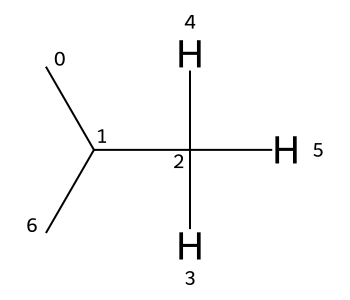

In [15]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = (350,300)

ps = Chem.SmilesParserParams()
ps.removeHs = False
m = Chem.MolFromSmiles('CC(C([H])([H])[H])[CH3]',ps)
m

In [16]:
m.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 3 imp: 1 hyb: SP3
	2 6 C chg: 0  deg: 4 exp: 4 imp: 0 hyb: SP3
	3 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	4 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	5 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	6 6 C chg: 0  deg: 1 exp: 4 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 2->3 order: 1
	3 2->4 order: 1
	4 2->5 order: 1
	5 1->6 order: 1


In [18]:
for aidx in (0,2,6):
    at = m.GetAtomWithIdx(aidx)
    print(f'{aidx}: implicit: {at.GetNumImplicitHs()}, explicit: {at.GetNumExplicitHs()}, total: {at.GetTotalNumHs(includeNeighbors=True)}')

0: implicit: 3, explicit: 0, total: 3
2: implicit: 0, explicit: 0, total: 3
6: implicit: 0, explicit: 3, total: 3


Of the three functions `atom.GetNumImplicitHs()`, `atom.GetNumExplicitHs`, and `atom.GetTotalNumHs()`, only `atom.GetTotalNumHs()` returns consistent results.

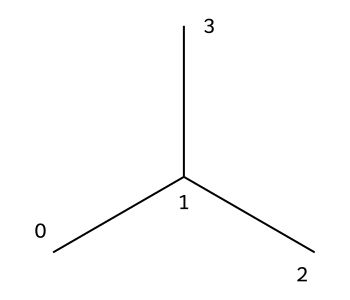

In [19]:
m_noh = Chem.RemoveHs(m)
m_noh

In [20]:
m_noh.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 3 imp: 1 hyb: SP3
	2 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	3 6 C chg: 0  deg: 1 exp: 4 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 1->3 order: 1


In [22]:
for aidx in (0,2,3):
    at = m_noh.GetAtomWithIdx(aidx)
    print(f'{aidx}: implicit: {at.GetNumImplicitHs()}, explicit: {at.GetNumExplicitHs()}, total: {at.GetTotalNumHs(includeNeighbors=True)}')

0: implicit: 3, explicit: 0, total: 3
2: implicit: 3, explicit: 0, total: 3
3: implicit: 0, explicit: 3, total: 3


It gets even more confusing:

In [23]:
m2 = Chem.MolFromSmiles('CC[H]')
m2.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 1 exp: 2 imp: 2 hyb: SP3
Bonds:
	0 0->1 order: 1


In [24]:
for aidx in (0,1):
    at = m2.GetAtomWithIdx(aidx)
    print(f'{aidx}: implicit: {at.GetNumImplicitHs()}, explicit: {at.GetNumExplicitHs()}, total: {at.GetTotalNumHs(includeNeighbors=True)}')

0: implicit: 3, explicit: 0, total: 3
1: implicit: 2, explicit: 1, total: 3


There is a similarly confusing situation with the results of `atom.GetExplicitValence()`, and `atom.GetImplicitValence()` (you see this above in the `exp` and `imp` entries of the debug output).

There is a reason for this mess, but it's not a good one.


## Solution (for your code)

Only use `atom.GetTotalNumHs()` and set the `includeNeighbors` argument to `True` if you want to find the total number of Hs connected to an atom or `False` if you know that you are working with hydrogen-suppressed molecules (the default in the RDKit) or if you only want to count the number of implicit Hs.

Use `atom.GetTotalValence()` if you want the sum of the valence of the atom's bonds and the number of implicit Hs.


## What I would like to change in the RDKit itself.

Get rid of the confusing distinction between "implicit" and "explicit" Hs that are not present in the graph... these should all just be considered to be "implicit" Hs. Hs that are in the graph can be considered "explicit" if necessary.

Concrete API changes connected to this:
- remove the functions `atom.GetNumImplicitHs()` and `atom.GetNumExplicitHs()`
- change the semantics of `atom.GetImplicitValence()` to return the count of the number of implicit Hs
- change the semantics of `atom.GetExplicitValence()` to return the sum of the valence of all bonds to the atom

## The way forward

I would also like to make this change in the 2025.03 release. If we decide to do that, as part of the 2024.09 release we will add warnings to the functions that are being modified or removed.

There will also be a blog post or two on this topic and some extra documentation about how to identify parts of your code that may need to be changed and how to change them.

# Stereochemistry and the RDKit

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2024.03.5


Start with a sample molecule with both atomic and bond stereochemistry

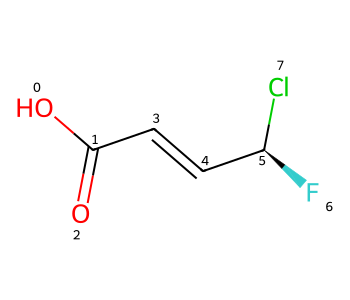

In [2]:
IPythonConsole.molSize = 350,300
IPythonConsole.drawOptions.addAtomIndices = True
m = Chem.MolFromSmiles('OC(=O)/C=C/[C@H](F)Cl')
m

In [3]:
m.Debug()

Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP2
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: SP2
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
	6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 17 Cl chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1 conj?: 1
	1 1->2 order: 2 conj?: 1
	2 1->3 order: 1 dir: / conj?: 1
	3 3->4 order: 2 stereo: E ats: (1 5) conj?: 1
	4 4->5 order: 1 dir: /
	5 5->6 order: 1
	6 5->7 order: 1


## Aside: the RDKit's representation of stereochemistry

Here's the sample molecule

![image.png](attachment:image.png)

Let's start with the chirality around atom 5; here's what `mol.Debug()` showed:
```
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
```

The important information here is `chi` and `nbrs`, which tell us that if we look from atom 4 to atom 5, we need to rotate counter-clockwise to go from atom 6 to atom 7.

Here's what `mol.Debug()` showed for the double bond:
```
	3 3->4 order: 2 stereo: E ats: (1 5) conj?: 1
```
This tells us that atoms 1 and 5 are on opposite sides of the double bond.

If we use the new stereo perception code (see below) we get `TRANS` instead of `E` for the bond stereo, but the meaning of the `ats` information is the same.
```
	3 3->4 order: 2 stereo: TRANS ats: (1 5) conj?: 1
```


In [4]:
Chem.SetUseLegacyStereoPerception(False)
m = Chem.MolFromSmiles('OC(=O)/C=C/[C@H](F)Cl')
Chem.SetUseLegacyStereoPerception(True)

m.Debug()

Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP2
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: SP2
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
	6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 17 Cl chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1 conj?: 1
	1 1->2 order: 2 conj?: 1
	2 1->3 order: 1 dir: / conj?: 1
	3 3->4 order: 2 stereo: TRANS ats: (1 5) conj?: 1
	4 4->5 order: 1 dir: /
	5 5->6 order: 1
	6 5->7 order: 1


## Changes to the way stereochemistry is extracted from 2D structures with wedged bonds
v2023.09.1

Extracting stereochemistry from 3D structures is easy, but it's a bit harder for 2D structures.

Here's an example molecule:
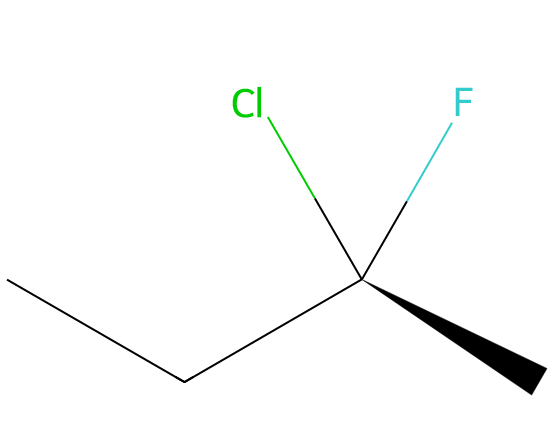

The RDKit needs to be able to use the 2D atomic coordinates here along with the bond wedging information to figure out what the rotation direction at the chiral center should be.

The previous implementation was complex and somewhat fragile at its core (years of patching and improvements made it work).

The new implementation shifts atoms at the end of wedged bonds a bit above the plane and atoms at the end of dashed bonds a bit below the plane and then applies the relatively straightforward code for extracting the stereo of 3D structures.

Thanks to Tad Hurst (at CDD) for the conversation which led me to realize that this approach was both possible and much simpler.

### A detail
(v2024.03.1)

The pseudo-3D perception strategy breaks down for T-shaped molecules (or, in general, molecules where the two non-wedged bonds are co-linear):
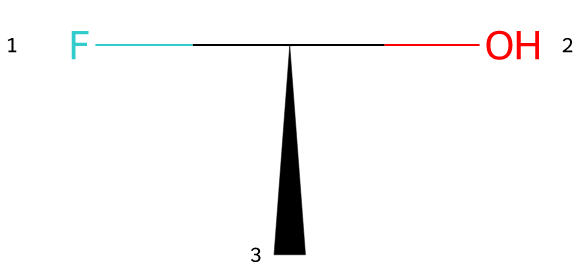

We resolve this by assuming that the "missing" atom (the H) is on the "other side" of the colinear bonds from the wedged atom:

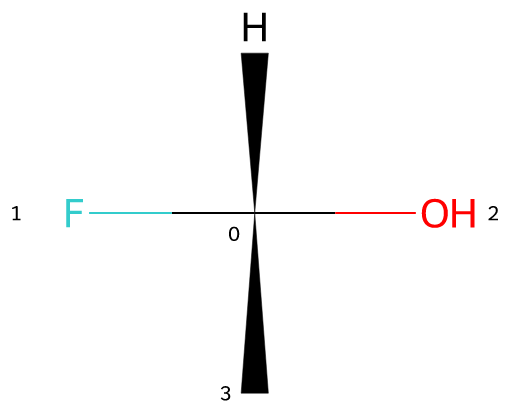

## "New" stereo perception code

This isn't actually particularly new, the original version was in the 2020.09.1 release, but I want to call attention to it now because using the new code will probably become the default with the 2025.03 release and this may require some adjustments in your code

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2024.03.5


Let's start with one of the more straightforward examples where the new code demonstrates its value:

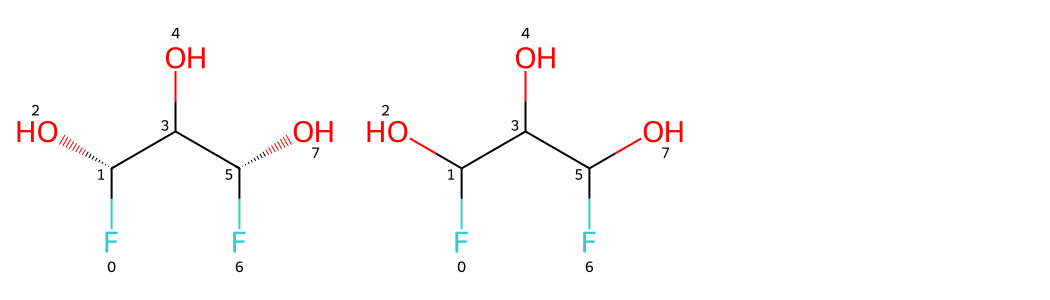

In [6]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = (350,300)

m1 = Chem.MolFromSmiles('F[C@H](O)C(O)[C@@H](F)O')
m2 = Chem.MolFromSmiles('F[CH](O)C(O)[CH](F)O')
Draw.MolsToGridImage([m1,m2],subImgSize=(350,300))

> Aside: in all of the examples here, we are copying the molecule before calling `Chem.FindMolChiralCenters()` because it caches some values on the molecule which can obscure the differences between the algorithms

In [7]:
Chem.FindMolChiralCenters(Chem.Mol(m1),includeUnassigned=True,useLegacyImplementation=True)

[(1, 'S'), (3, '?'), (5, 'R')]

In [8]:
Chem.FindMolChiralCenters(Chem.Mol(m2),includeUnassigned=True,useLegacyImplementation=True)

[(1, '?'), (5, '?')]

That is clearly wrong, but if we disable the legacy implementation then everything is fine:

In [9]:
Chem.FindMolChiralCenters(Chem.Mol(m1),includeUnassigned=True,useLegacyImplementation=False)

[(1, 'S'), (3, '?'), (5, 'R')]

In [10]:
Chem.FindMolChiralCenters(Chem.Mol(m2),includeUnassigned=True,useLegacyImplementation=False)

[(1, '?'), (3, '?'), (5, '?')]

The default for `FindMolChiralCenters()` is to use the old code:

In [11]:
Chem.FindMolChiralCenters(Chem.Mol(m2),includeUnassigned=True)

[(1, '?'), (5, '?')]

This is, of course, not the whole story. What's more interesting is what happens when the molecule is parsed and the initial stereochemistry assignment is done.

To demonstrate this, I'll also show how to turn the legacy code on (the default) or off via a function in the `rdkit.Chem` module.

Here's a molecule that causes problems for the old algorithm.

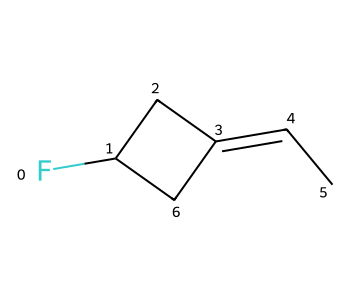

In [12]:
Chem.SetUseLegacyStereoPerception(True)  # < make sure we're using legacy stereo perception
m3 = Chem.MolFromSmiles('F[C@H]1C/C(=C/C)C1')
m3

Here atom 1 actually is a chiral center and the double bond is a stereo bond, but the old algorithm can't handle this:

In [13]:
m3.Debug()

Atoms:
	0 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 3 imp: 1 hyb: SP3
	2 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	3 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	6 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 2->3 order: 1
	3 3->4 order: 2
	4 4->5 order: 1
	5 3->6 order: 1
	6 6->1 order: 1


The new algorithm, on the other hand, is fine:

In [14]:
Chem.SetUseLegacyStereoPerception(False) # < make sure we're using The new stereo code
m3 = Chem.MolFromSmiles('F[C@H]1C/C(=C/C)C1')
m3.Debug()

Atoms:
	0 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CW nbrs:[0 2 6]
	2 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	3 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	6 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 2->3 order: 1 dir: /
	3 3->4 order: 2 stereo: TRANS ats: (2 5)
	4 4->5 order: 1 dir: /
	5 3->6 order: 1
	6 6->1 order: 1


Note that when the the global `useLegacyStereoPerception` value is False, `Chem.FindMolChiralCenters()` will use the new code by default:

The new code is not already the default because there are a couple of behavior changes which affect some end-user code. Specifically:

1. Chiral atoms no longer have a property `_CIPCode` with their pseudo-CIP labels
2. Double bonds will be labelled `CIS` or `TRANS` instead of the pseudo-CIP values `R` and `S`

I use the phrase "pseudo-CIP" here because the labels that the legacy code assigns are only correct CIP labels in the simplest of cases. For anything complicated (and check out this publication to see how complicated it can get: https://pubs.acs.org/doi/10.1021/acs.jcim.8b00324) the results are consistent, but likely incorrect. 

> For those who are interested, the pseudo-CIP algorithm that the legacy code uses is described in an article from Paul Labute that's unfortunately only still available from the wayback machine: https://web.archive.org/web/20030920051139/http://www.chemcomp.com/Journal_of_CCG/Articles/chiral.html



Let's look at these differences:

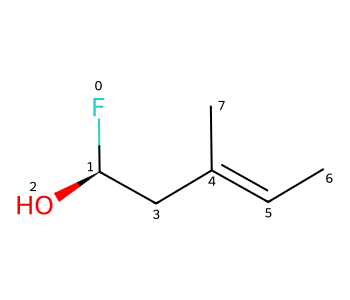

In [21]:
Chem.SetUseLegacyStereoPerception(True) # < make sure we're using The new stereo code
m4_old = Chem.MolFromSmiles('F[C@H](O)C/C(=C/C)C')
Chem.SetUseLegacyStereoPerception(False) # < make sure we're using The new stereo code
m4_new = Chem.MolFromSmiles('F[C@H](O)C/C(=C/C)C')

m4_old

In [22]:
print('atom props:')
print(m4_old.GetAtomWithIdx(1).GetPropsAsDict())
print(m4_new.GetBondWithIdx(1).GetPropsAsDict())

atom props:
{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x7247993175c0>, '_CIPRank': 5, '_ChiralityPossible': 1, '_CIPCode': 'S'}
{}


In [23]:
print('bond stereo:', m4_old.GetBondWithIdx(4).GetStereo(),m4_new.GetBondWithIdx(4).GetStereo())

bond stereo: STEREOE STEREOTRANS


If you need CIP labels for atoms and bonds, use the CIP labelling code, this assigns CIP labels that should be correct:

In [24]:
from rdkit.Chem import rdCIPLabeler
rdCIPLabeler.AssignCIPLabels(m4_new)
print('atom:',m4_new.GetAtomWithIdx(1).GetPropsAsDict())
print('bond:',m4_new.GetBondWithIdx(4).GetPropsAsDict())

atom: {'_chiralAtomRank': 7, '_ChiralityPossible': 1, '_CIPCode': 'S'}
bond: {'_CIPCode': 'E'}


If you just want something to rank the atoms in a molecule a way that takes stereochemistry into account, you can do that by getting the canonical atom ranking without tie breaking, this is *considerably* faster than calculating CIP ranks:

In [25]:
list(Chem.CanonicalRankAtoms(m4_new,breakTies=True))

[3, 7, 2, 5, 6, 4, 0, 1]

Further illustration of the CIP stereo labels:

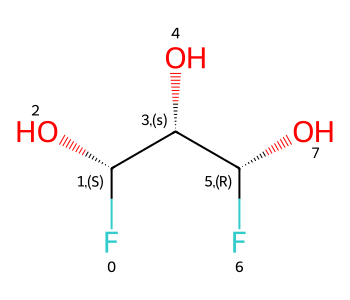

In [28]:
m5 = Chem.MolFromSmiles('F[C@H](O)[C@H](O)[C@@H](F)O')
rdCIPLabeler.AssignCIPLabels(m5)

IPythonConsole.drawOptions.addStereoAnnotation = True
m5

In [30]:
IPythonConsole.drawOptions.addStereoAnnotation = False

I will be blogging more on this topic in the upcoming months

In [20]:
Chem.SetUseLegacyStereoPerception(True)

## Atropisomer support
(2024.03.1)

Developer: Tad Hurst


Rotationally hindered single bonds that give rise to chirality:

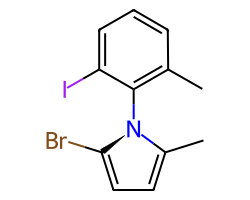

No attempt is made to determine whether or not rotation is actually hindered; if you specify a bond as atropisomeric and it matches the requirements then it will be considered atropisomeric.

Requirements:

- There must be a dashed or wedged bond on one side of the bond. The direction of the wedge is ignored if there are 3D coordinates.
- The bond must be a single bond between SP2 hybridized atoms.
- The neighboring bonds must be single, double or aromatic. 
- If there are two groups on either end, those groups must be different as per CIP rules. 
- The current implementation requires atomic coordinates except for in certain cases.

Atropisomers are currently parsed from, and written to, Mol, CDXML, MRV, and CXSmiles


This is work in progress and we'll continue adding functionality.

For more information:
https://rdkit.org/docs/RDKit_Book.html#atropisomeric-bonds


In [21]:
IPythonConsole.molSize = 350,300

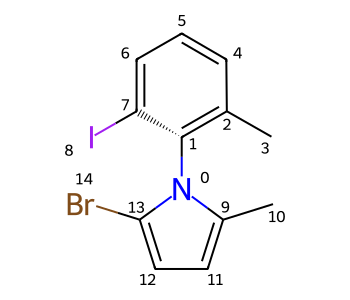

In [22]:
IPythonConsole.drawOptions.addAtomIndices = True
m = Chem.MolFromSmiles('N1(C2C(C)=CC=CC=2I)C(C)=CC=C1Br |wU:1.1,(16.58,-10.58,;16.58,-9.58,;17.45,-9.08,;18.31,-9.57,;17.44,-8.08,;16.58,-7.58,;15.71,-8.08,;15.71,-9.08,;14.84,-9.58,;17.38,-11.17,;18.34,-10.87,;17.08,-12.12,;16.07,-12.12,;15.77,-11.17,;14.81,-10.87,)|')
m

In [23]:
m.Debug()

Atoms:
	0 7 N chg: 0  deg: 3 exp: 3 imp: 0 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	6 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	7 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	8 53 I chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	9 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	10 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	11 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	12 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	13 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	14 35 Br chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1 stereo: CCW bonds: (8 14 1 15) conj?: 1
	1 1->2 order: a conj?: 1 aromatic?: 1
	2 2->3 order: 1
	3 2->4 order: a conj?: 1 aromatic?: 1
	4 4->5 order: a conj?: 1 aromatic?: 1
	5 5->6 order

Correct CIP assignment is done:

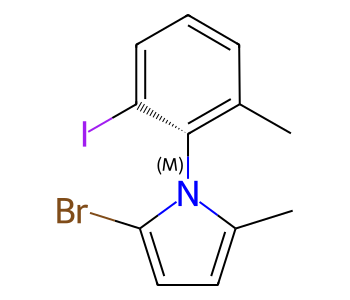

In [24]:
from rdkit.Chem import rdCIPLabeler
rdCIPLabeler.AssignCIPLabels(m)
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True

m

The information is used in conformer generation:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

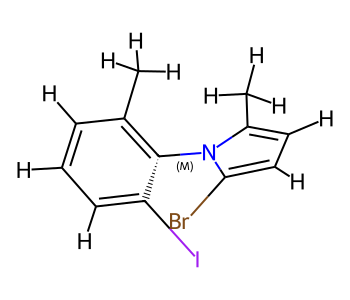

In [25]:
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f

mh = Chem.AddHs(m)
rdDistGeom.EmbedMolecule(mh,ps)
mh

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

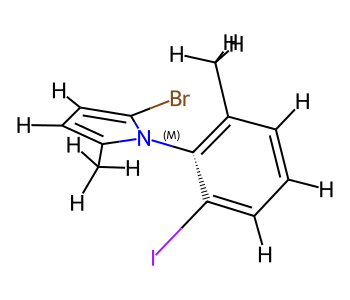

In [26]:
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d+4
ps.enforceChirality = False

mh2 = Chem.AddHs(m)
rdDistGeom.EmbedMolecule(mh2,ps)
mh2

### The representation

Here's the molecule with bond indices shown:
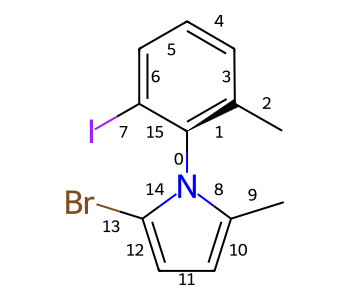

Here's what the output from `mol.Debug()` shows:
> `0 0->1 order: 1 stereo: CCW bonds: (8 14 1 15) conj?: 1`

This tells us that when looking down bond 0, i.e. from atom 0 (the N) to atom 1 (the C), the rotation between bond 8 (the first bond on atom 0) and bond 1 (the first bond on atom 1) is counter-clockwise.


### Perception of atropisomers from 3D

Atropisomeric stereo is only assigned if there is wedged bond on one side of the atropisomeric bond. The nature of the wedging itself is ignored: the 3D coordinates are used to derive the atropisomeric assignment

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

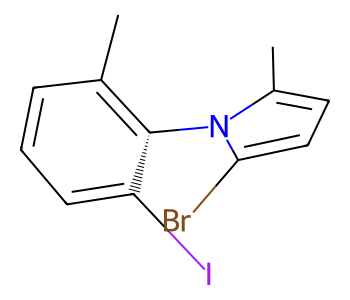

In [27]:
m = Chem.MolFromMolBlock('''
     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 15 16 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N 0.820728 -0.340013 0.413910 0
M  V30 2 C -0.505633 -0.463154 -0.098058 0
M  V30 3 C -1.435394 0.542219 0.079201 0
M  V30 4 C -1.107937 1.782858 0.799883 0
M  V30 5 C -2.727100 0.393180 -0.433634 0
M  V30 6 C -2.965917 -0.793250 -1.097542 0
M  V30 7 C -2.085065 -1.834330 -1.308981 0
M  V30 8 C -0.816423 -1.635282 -0.779440 0
M  V30 9 I 0.622228 -3.161616 -1.039338 0
M  V30 10 C 1.866434 0.341279 -0.034489 0
M  V30 11 C 1.844110 1.176490 -1.264158 0
M  V30 12 C 2.919280 0.145435 0.800063 0
M  V30 13 C 2.513420 -0.705489 1.829463 0
M  V30 14 C 1.183042 -0.988630 1.548767 0
M  V30 15 Br 0.194117 -2.139132 2.711021 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 1 3 5
M  V30 5 2 5 6
M  V30 6 1 6 7
M  V30 7 2 7 8
M  V30 8 1 8 9
M  V30 9 1 1 10
M  V30 10 1 10 11
M  V30 11 2 10 12
M  V30 12 1 12 13
M  V30 13 2 13 14
M  V30 14 1 14 15
M  V30 15 1 1 14
M  V30 16 1 2 8 CFG=3
M  V30 END BOND
M  V30 END CTAB
M  END''')
m

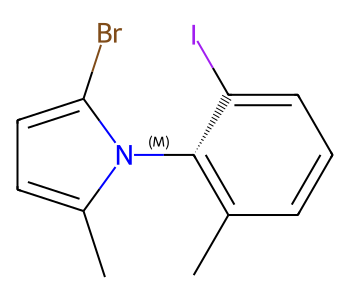

In [28]:
IPythonConsole.drawOptions.useMolBlockWedging = True
m2 = Chem.Mol(m)
m2.RemoveAllConformers()
rdCIPLabeler.AssignCIPLabels(m2)
m2

If the wedged bond is not present in the mol block, then the atropisomeric bond will not be perceived:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

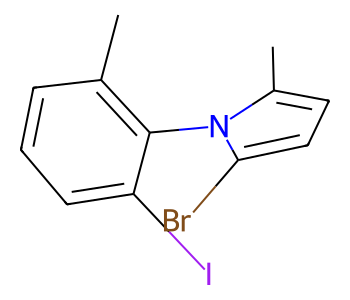

In [29]:
m_nowedge = Chem.MolFromMolBlock('''
     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 15 16 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N 0.820728 -0.340013 0.413910 0
M  V30 2 C -0.505633 -0.463154 -0.098058 0
M  V30 3 C -1.435394 0.542219 0.079201 0
M  V30 4 C -1.107937 1.782858 0.799883 0
M  V30 5 C -2.727100 0.393180 -0.433634 0
M  V30 6 C -2.965917 -0.793250 -1.097542 0
M  V30 7 C -2.085065 -1.834330 -1.308981 0
M  V30 8 C -0.816423 -1.635282 -0.779440 0
M  V30 9 I 0.622228 -3.161616 -1.039338 0
M  V30 10 C 1.866434 0.341279 -0.034489 0
M  V30 11 C 1.844110 1.176490 -1.264158 0
M  V30 12 C 2.919280 0.145435 0.800063 0
M  V30 13 C 2.513420 -0.705489 1.829463 0
M  V30 14 C 1.183042 -0.988630 1.548767 0
M  V30 15 Br 0.194117 -2.139132 2.711021 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 1 3 5
M  V30 5 2 5 6
M  V30 6 1 6 7
M  V30 7 2 7 8
M  V30 8 1 8 9
M  V30 9 1 1 10
M  V30 10 1 10 11
M  V30 11 2 10 12
M  V30 12 1 12 13
M  V30 13 2 13 14
M  V30 14 1 14 15
M  V30 15 1 1 14
M  V30 16 1 2 8
M  V30 END BOND
M  V30 END CTAB
M  END''')
m_nowedge

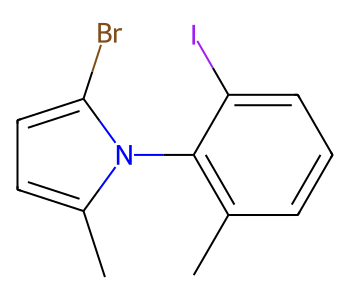

In [30]:
IPythonConsole.drawOptions.useMolBlockWedging = True
m2 = Chem.Mol(m_nowedge)
m2.RemoveAllConformers()
rdCIPLabeler.AssignCIPLabels(m2)
m2

In [31]:
IPythonConsole.drawOptions.useMolBlockWedging = False

### Atropisomers without a conformer

Generally you need a conformer (2D or 3D) for atropisomerism to be perceived, but we adopt a convention to allow expressing atropisomers in CXSMILES without providing coordinates:

> The atropisomeric bond’s stereochemistry is CCW when the bond to the lowest-numbered neighbor of the start atom is wedged. It's CW if the bond is dashed.

For example, if this molecule were provided with the specified wedging but with no coordinates, the atropisomeric bond between atoms 7 and 8 would be CCW:
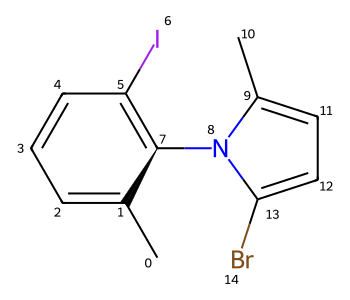

Let's look at that molecule and what Debug shows.

Start by drawing it with the bond IDs:

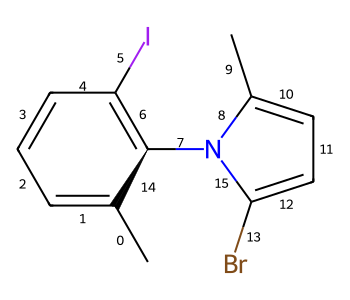

In [51]:
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addBondIndices = True

IPythonConsole.drawOptions.useMolBlockWedging = True
m = Chem.MolFromSmiles('CC1=CC=CC(I)=C1N1C(C)=CC=C1Br |wU:7.7|')
m

In [52]:
m.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	6 53 I chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	8 7 N chg: 0  deg: 3 exp: 3 imp: 0 hyb: SP2 arom?: 1
	9 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	10 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	11 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	12 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	13 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2 arom?: 1
	14 35 Br chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: a conj?: 1 aromatic?: 1
	2 2->3 order: a conj?: 1 aromatic?: 1
	3 3->4 order: a conj?: 1 aromatic?: 1
	4 4->5 order: a conj?: 1 aromatic?: 1
	5 5->6 order: 1
	6 5->7 order:

And if we have a dashed bond, we get CW:

STEREOATROPCW


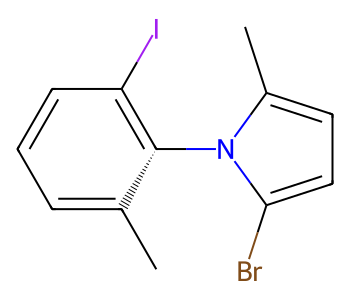

In [56]:
IPythonConsole.drawOptions.addBondIndices = False
m = Chem.MolFromSmiles('CC1=CC=CC(I)=C1N1C(C)=CC=C1Br |wD:7.7|')
print(m.GetBondBetweenAtoms(7,8).GetStereo())
m

In [38]:
IPythonConsole.drawOptions.useMolBlockWedging = False

# MinimalLib improvements
(ongoing)

These affect the JavaScript wrappers as well as the CFFI interface

Paolo is going to talk more about this



# PostgreSQL Cartridge improvements
(ongoing)

You can now `conda install -c conda-forge rdkit-postgresql` (Contributor: Steve Kearnes), v2024.03.5 

- Support for using Beilstein generics (Contributor: Jonathan Bisson), v2023.09
- Support generalized substructure search, v2023.09
- Performance improvements for molecular equality testing

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
%load_ext sql

Deploy Panel apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


10 rows affected.


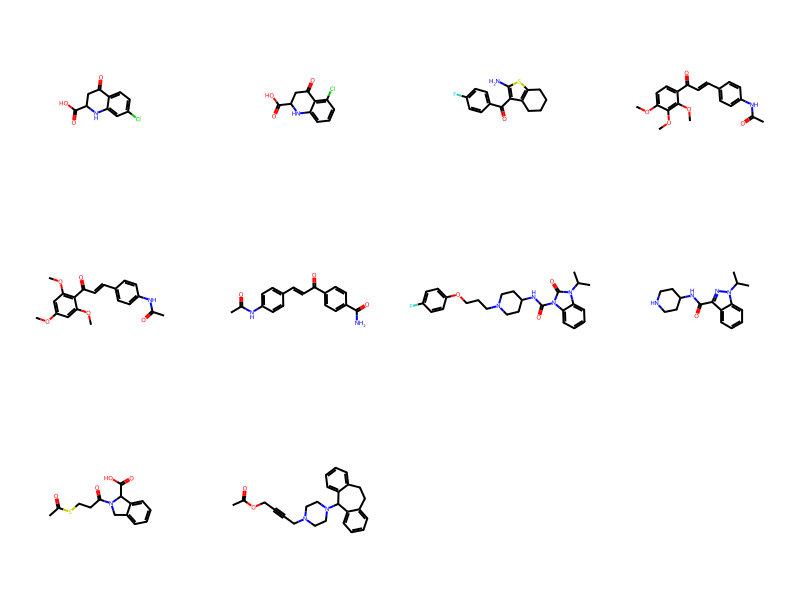

In [2]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @>> mol_adjust_query_properties('O=C(-*)(-*) |$;;ARY_p;ARY_p$|'::mol, \
                        '{"adjustDegree": false, "makeDummiesQueries": true}')\
            order by molregno asc limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)

In [3]:
%sql postgresql://localhost/chembl_31 \
  select  'CC(=O)C'::mol @>> mol_adjust_query_properties('O=C(-*)(-*) |$;;ARY_p;ARY_p$|'::mol, \
                        '{"setGenericQueryFromProperties": true, "adjustDegree": false}');

1 rows affected.


?column?
False


10 rows affected.


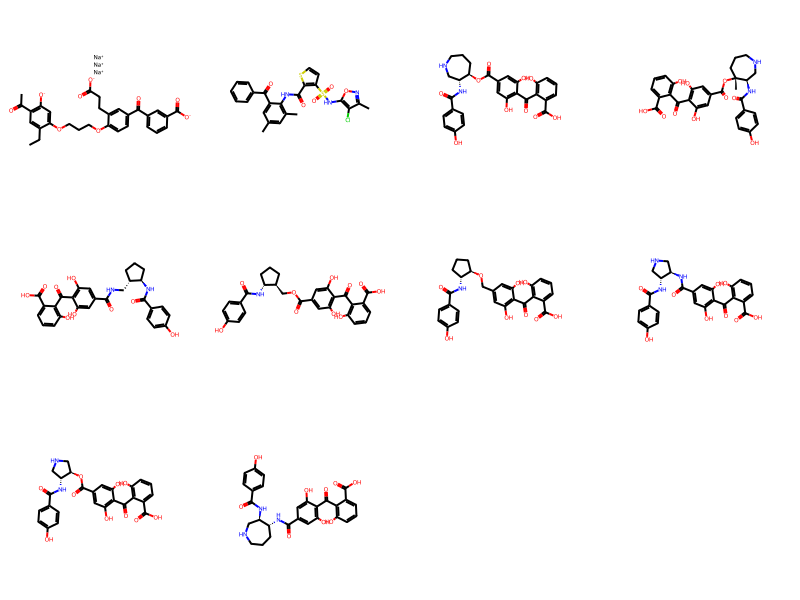

In [4]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @>> mol_adjust_query_properties('O=C(-*)(-*) |$;;ARY_p;ARY_p$|'::mol, \
                        '{"setGenericQueryFromProperties": true, "adjustDegree": false, "makeDummiesQueries": true}')\
            order by molregno asc limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)

Generalized substructure search

In [5]:
mb = '''
     RDKit          2D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 7 7 1 0 0
M  V30 BEGIN ATOM
M  V30 1 C 1.208608 -2.457143 0.000000 0
M  V30 2 C 2.445787 -1.742857 0.000000 0
M  V30 3 C 2.445787 -0.314286 0.000000 0
M  V30 4 N 1.208608 0.400000 0.000000 0
M  V30 5 C -0.028571 -0.314286 0.000000 0
M  V30 6 C -0.028571 -1.742857 0.000000 0
M  V30 7 O -1.265751 0.400000 0.000000 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 1 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 1 6 1
M  V30 7 1 5 7
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 DAT 0 ATOMS=(1 7) FIELDDISP="    0.0000    0.0000    DR    ALL  0 0" -
M  V30 QUERYTYPE=SMARTSQ QUERYOP== FIELDDATA="[#8&X1]"
M  V30 END SGROUP
M  V30 END CTAB
M  END
$$$$
'''

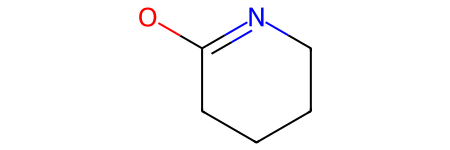

In [6]:
m = Chem.MolFromMolBlock(mb)
m

In [7]:
Chem.MolToSmarts(m)

'[#6]1-[#6]-[#6]-[#7]=[#6](-[#6]-1)-[#8&X1]'

In [8]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_from_ctab(:mb)\
            order by molregno asc limit 10;
if not len(d):
    raise ValueError('no matches!')
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)


0 rows affected.


ValueError: no matches!

10 rows affected.


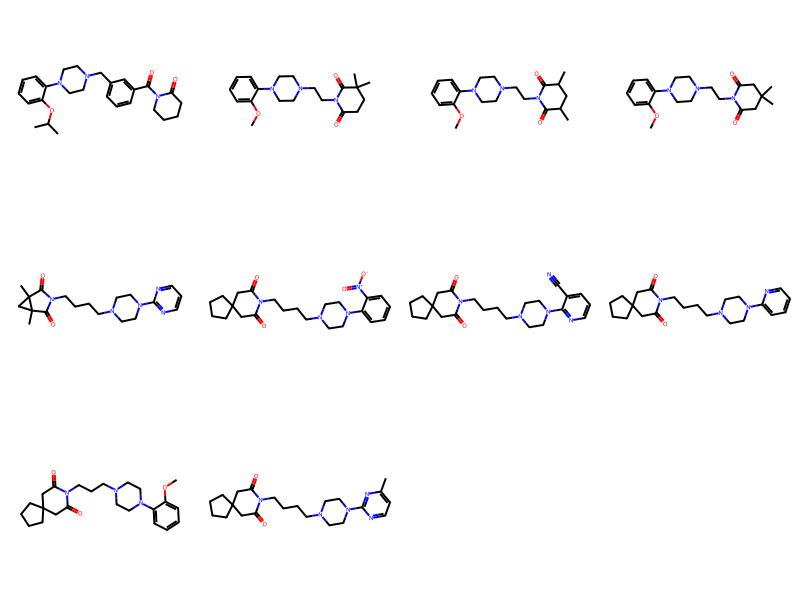

In [9]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_to_xqmol(mol_from_ctab(:mb))\
            order by molregno asc limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)


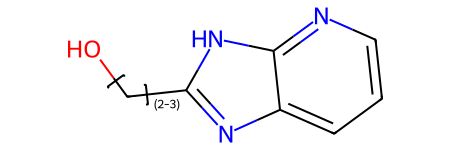

In [10]:
qry = Chem.MolFromSmiles('OCc1nc2cccnc2[nH]1 |LN:1:2.3|')
qry

6 rows affected.


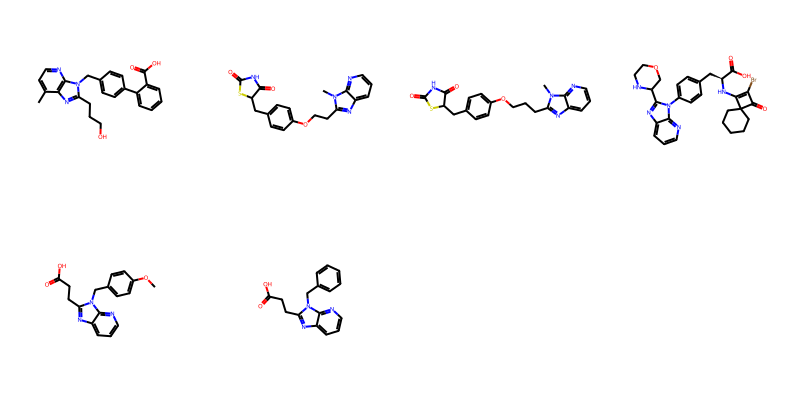

In [11]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_to_xqmol('OCc1nc2cccnc2[nH]1 |LN:1:2.3|')\
            limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)


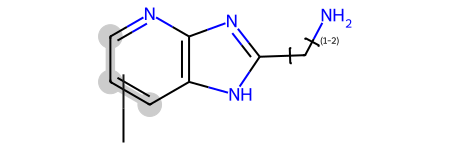

In [12]:
mb = '''qry 
  Mrv2305 09052314502D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 13 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N -4.75 1.9567 0 0
M  V30 2 C -6.0837 1.1867 0 0
M  V30 3 C -6.0837 -0.3534 0 0
M  V30 4 C -4.75 -1.1234 0 0
M  V30 5 C -3.4163 -0.3534 0 0
M  V30 6 C -3.4163 1.1867 0 0
M  V30 7 N -1.9692 1.7134 0 0
M  V30 8 N -1.8822 -0.7768 0 0
M  V30 9 C -1.0211 0.4999 0 0
M  V30 10 C 0.5179 0.5536 0 0
M  V30 11 N 1.2409 1.9133 0 0
M  V30 12 * -5.6391 -0.0967 0 0
M  V30 13 C -5.6391 -2.4067 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 8 9
M  V30 8 1 7 6
M  V30 9 1 5 8
M  V30 10 2 7 9
M  V30 11 1 9 10
M  V30 12 1 10 11
M  V30 13 1 12 13 ENDPTS=(3 4 3 2) ATTACH=ANY
M  V30 END BOND
M  V30 LINKNODE 1 2 2 10 9 10 11
M  V30 END CTAB
M  END'''
Chem.MolFromMolBlock(mb)

In [3]:
mb2 = '''qry 
  Mrv2305 09052314502D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 13 0 0 0
M  V30 BEGIN ATOM
M  V30 1 N -4.75 1.9567 0 0
M  V30 2 C -6.0837 1.1867 0 0
M  V30 3 C -6.0837 -0.3534 0 0
M  V30 4 C -4.75 -1.1234 0 0
M  V30 5 C -3.4163 -0.3534 0 0
M  V30 6 C -3.4163 1.1867 0 0
M  V30 7 N -1.9692 1.7134 0 0
M  V30 8 N -1.8822 -0.7768 0 0
M  V30 9 C -1.0211 0.4999 0 0
M  V30 10 C 0.5179 0.5536 0 0
M  V30 11 N 1.2409 1.9133 0 0
M  V30 12 * -5.6391 -0.0967 0 0
M  V30 13 C -5.6391 -2.4067 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 8 9
M  V30 8 1 7 6
M  V30 9 1 5 8
M  V30 10 2 7 9
M  V30 11 1 9 10
M  V30 12 1 10 11
M  V30 13 1 12 13 ENDPTS=(3 4 3 2) ATTACH=ANY
M  V30 END BOND
M  V30 END CTAB
M  END'''
tm = Chem.MolFromMolBlock(mb2)

In [5]:
Chem.MolToV3KMolBlock(tm)

'qry \n     RDKit          2D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 13 13 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 N -4.750000 1.956700 0.000000 0\nM  V30 2 C -6.083700 1.186700 0.000000 0\nM  V30 3 C -6.083700 -0.353400 0.000000 0\nM  V30 4 C -4.750000 -1.123400 0.000000 0\nM  V30 5 C -3.416300 -0.353400 0.000000 0\nM  V30 6 C -3.416300 1.186700 0.000000 0\nM  V30 7 N -1.969200 1.713400 0.000000 0\nM  V30 8 N -1.882200 -0.776800 0.000000 0\nM  V30 9 C -1.021100 0.499900 0.000000 0\nM  V30 10 C 0.517900 0.553600 0.000000 0\nM  V30 11 N 1.240900 1.913300 0.000000 0\nM  V30 12 * -5.639100 -0.096700 0.000000 0\nM  V30 13 C -5.639100 -2.406700 0.000000 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 2 1 2\nM  V30 2 1 2 3\nM  V30 3 2 3 4\nM  V30 4 1 4 5\nM  V30 5 2 5 6\nM  V30 6 1 1 6\nM  V30 7 1 8 9\nM  V30 8 1 7 6\nM  V30 9 1 5 8\nM  V30 10 2 7 9\nM  V30 11 1 9 10\nM  V30 12 1 10 11\nM  V30 13 1 12 13 ENDPTS=(3 4 3 2) ATTACH=ANY\nM  V30 END BOND\nM  V30 EN

8 rows affected.


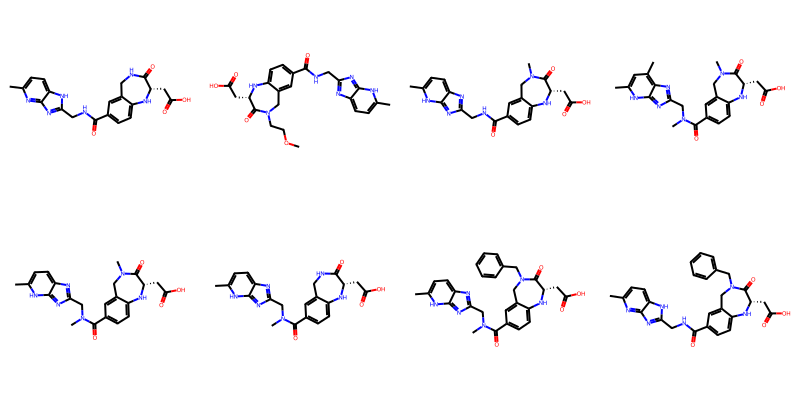

In [13]:
d = %sql postgresql://localhost/chembl_31 \
  select * from rdk.million_mols where m @> mol_to_xqmol(mol_from_ctab(:mb))\
            limit 10;
ms = [Chem.MolFromSmiles(y) for x,y in d]
Draw.MolsToGridImage(ms,molsPerRow=4)


# New Features


In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2024.03.5


## Improved output from mol.Debug()
2024.03.1


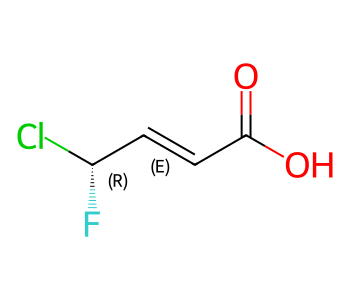

In [32]:
m = Chem.MolFromSmiles('OC(=O)/C=C/[C@H](F)Cl')
m

In [33]:
m.Debug()

Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP2
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: SP2
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[4 6 7]
	6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
	7 17 Cl chg: 0  deg: 1 exp: 1 imp: 0 hyb: SP3
Bonds:
	0 0->1 order: 1 conj?: 1
	1 1->2 order: 2 conj?: 1
	2 1->3 order: 1 dir: / conj?: 1
	3 3->4 order: 2 stereo: E ats: (1 5) conj?: 1
	4 4->5 order: 1 dir: /
	5 5->6 order: 1
	6 5->7 order: 1


What this looked like before:
```
In [7]: m.Debug()
Atoms:
	0 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: 3 arom?: 0 chi: 0
	1 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 3 arom?: 0 chi: 0
	2 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: 3 arom?: 0 chi: 0
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
	5 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 4 arom?: 0 chi: 2
	6 9 F chg: 0  deg: 1 exp: 1 imp: 0 hyb: 4 arom?: 0 chi: 0
	7 17 Cl chg: 0  deg: 1 exp: 1 imp: 0 hyb: 4 arom?: 0 chi: 0
Bonds:
	0 0->1 order: 1 conj?: 1 aromatic?: 0
	1 1->2 order: 2 conj?: 1 aromatic?: 0
	2 1->3 order: 1 dir: 4 conj?: 1 aromatic?: 0
	3 3->4 order: 2 stereo: 3 stereoAts: (1 5) conj?: 1 aromatic?: 0
	4 4->5 order: 1 dir: 4 conj?: 0 aromatic?: 0
	5 5->6 order: 1 conj?: 0 aromatic?: 0
	6 5->7 order: 1 conj?: 0 aromatic?: 0
```

## Change to the way valences are calculated for charged atoms
v2024.09.1

The RDKit used to use some complex (byzantine?) logic for figuring out what valences were allowed for charged atoms. The new approach draws on the idea of isoelectronic species and is very simple. Here are some examples:
- `N+` is equivalent to `C`, so it accepts a valence of 4 (the allowed valence of C)
- `N-` is equivalent to `O`, so it accepts a valence of 2 (the allowed valence of O)
- `P-` is equivalent to `S`, so it accepts valences of 2, 4, or 6 (the allowed valences of S)

Additionally, some chemically unreasonable valences that were previously accepted have been removed. These are:
- Al 6
- Si 6
- P 7
- As 7
- Sb 7
- Bi 7

This should not affect most code, but it's good to understand what is going on in case you encounter any strangeness.

## Improvements to GetBestRMS

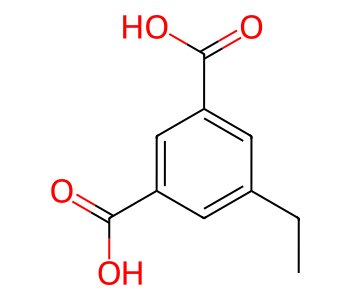

In [114]:
m = Chem.MolFromSmiles('CCc1cc(C(=O)O)cc(C(=O)O)c1')
m

In [73]:
from rdkit.Chem import rdDistGeom

mh = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f
cids = rdDistGeom.EmbedMultipleConfs(mh,100,ps)

In [76]:
import py3Dmol
def drawit(ms, p=None, confId=-1, removeHs=False,colors=('cyanCarbon','blueCarbon','redCarbon')):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,m in enumerate(ms):
            if removeHs:
                m = Chem.RemoveHs(m)
            IPythonConsole.addMolToView(m,p,confId=confId)
        for i,m in enumerate(ms):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

In [117]:
m1 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[0]))
m2 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[1]))

drawit([m1,m2])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [118]:
m1 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[0]))
m2 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[1]))
from rdkit.Chem import rdMolAlign
print(rdMolAlign.GetBestRMS(m1,m2,))
drawit([m1,m2])

0.07318973681172684


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Above the carboxyl groups were treated symmetrically. This was added in v2022.09.1 as the default. It can be turned off:

In [119]:
m1 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[0]))
m2 = Chem.RemoveHs(Chem.Mol(mh,confId=cids[1]))
from rdkit.Chem import rdMolAlign
    print(rdMolAlign.GetBestRMS(m1,m2,symmetrizeConjugatedTerminalGroups=False))
drawit([m1,m2])

0.853061645823018


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This is what used to be required to get the full RMSD matrix between the conformers:

In [120]:
def alignAllConfs(m,cids):
    res = []
    for i in range(len(cids)):
        for j in range(i):
            res.append(rdMolAlign.GetBestRMS(m,m,prbId=cids[j],refId=cids[i]))
    return res

In [126]:
m_noh = Chem.RemoveHs(mh)
rmsds = alignAllConfs(m_noh,cids)
print(len(rmsds))
print(rmsds[:5])

4950
[0.07318973681172684, 0.0819297838147849, 0.06087784074708799, 0.11706427510985265, 0.11105625692087649]


A convenience function `GetAllConformerBestRMS()` was added in v2023.09.3

In [127]:
m_noh = Chem.RemoveHs(mh)
rmsds = rdMolAlign.GetAllConformerBestRMS(m_noh)
print(len(rmsds))
print(rmsds[:5])

4950
(0.07318973681171298, 0.08192978381480967, 0.06087784074707966, 0.1170642751409294, 0.11105625692087191)


The new function only has to do the substructure matching once and has less Python/C++ overhead, so it's a lot faster:

In [123]:
m_noh = Chem.RemoveHs(mh)
%timeit rmsds = alignAllConfs(m_noh,cids)

245 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [124]:
m_noh = Chem.RemoveHs(mh)
%timeit rmsds = rdMolAlign.GetAllConformerBestRMS(m_noh)

46.1 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It can also use multiple threads simultaneously:

In [125]:
m_noh = Chem.RemoveHs(mh)
%timeit rmsds = rdMolAlign.GetAllConformerBestRMS(m_noh,numThreads=4)

15.7 ms ± 91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Conformer generation improvements

### Optional sequential random-number seeds in conformer generator
(2023.09)

This lets you generate sets of conformers for a molecule using multiple processes in an easily reproducible manner.

In [26]:
from rdkit.Chem import rdDistGeom
ps = rdDistGeom.ETKDGv3()
ps.enableSequentialRandomSeeds = True
ps.randomSeed = 0xf00d

vemurafenib = Chem.MolFromSmiles('CCCS(=O)(=O)Nc1ccc(F)c(c1F)C(=O)c2c[nH]c3c2cc(cn3)c4ccc(Cl)cc4')
mol = Chem.AddHs(vemurafenib)

mcp1 = Chem.Mol(mol)
rdDistGeom.EmbedMultipleConfs(mcp1,100,ps)

mcp2 = Chem.Mol(mol)
rdDistGeom.EmbedMultipleConfs(mcp2,50,ps)

ps.randomSeed += 50
mcp3 = Chem.Mol(mol)
rdDistGeom.EmbedMultipleConfs(mcp3,50,ps)

ps1 = mcp1.GetConformer(0).GetPositions()
ps2 = mcp2.GetConformer(0).GetPositions()
print(ps1[:3])
print(ps2[:3])

print('-------------')
ps1 = mcp1.GetConformer(50).GetPositions()
ps2 = mcp3.GetConformer(0).GetPositions()
print(ps1[:3])
print(ps2[:3])



[[-7.85726688 -1.79056102 -0.78340598]
 [-7.49722325 -0.35965765 -1.0803023 ]
 [-5.98464363 -0.15957798 -1.08659822]]
[[-7.85726688 -1.79056102 -0.78340598]
 [-7.49722325 -0.35965765 -1.0803023 ]
 [-5.98464363 -0.15957798 -1.08659822]]
-------------
[[ 7.6595696  -1.0102534   1.20951695]
 [ 6.77404853 -0.21689807  2.11178942]
 [ 5.4101534   0.0556143   1.53492455]]
[[ 7.6595696  -1.0102534   1.20951695]
 [ 6.77404853 -0.21689807  2.11178942]
 [ 5.4101534   0.0556143   1.53492455]]


### RMSD calculation
v2024.03.1

By default the RMSD pruning of conformers now symmetrizes terminal conjugated groups

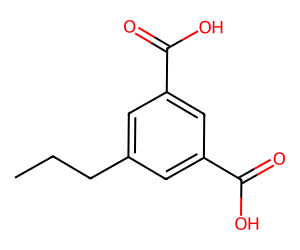

In [68]:
IPythonConsole.molSize = 300,250
m = Chem.MolFromSmiles('CCCc1cc(C(=O)O)cc(C(=O)O)c1')
m

In [111]:
m = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f
ps.pruneRmsThresh = 0.2
cids = rdDistGeom.EmbedMultipleConfs(m,10,ps)
len(cids)

3

In [112]:
from rdkit.Chem import rdMolAlign


for i in range(len(cids)):
    for j in range(i):
        m1 = Chem.RemoveHs(Chem.Mol(m,confId=cids[i]))
        m2 = Chem.RemoveHs(Chem.Mol(m,confId=cids[j]))
        rms1 = rdMolAlign.GetBestRMS(m1,m2)
        rms2 = rdMolAlign.GetBestRMS(m1,m2,symmetrizeConjugatedTerminalGroups=False)
        print(f'{i}, {j}: {rms1:.2f}, {rms2:.2f}')

drawit([m1,m2])

1, 0: 0.54, 0.99
2, 0: 0.53, 0.88
2, 1: 0.54, 0.98


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [117]:
m = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f
ps.pruneRmsThresh = 0.2
ps.symmetrizeConjugatedTerminalGroupsForPruning = False

cids = rdDistGeom.EmbedMultipleConfs(m,10,ps)
len(cids)

8

In [122]:
from rdkit.Chem import rdMolAlign


for i in range(len(cids)):
    for j in range(i):
        m1 = Chem.RemoveHs(Chem.Mol(m,confId=cids[i]))
        m2 = Chem.RemoveHs(Chem.Mol(m,confId=cids[j]))
        rms1 = rdMolAlign.GetBestRMS(m1,m2)
        rms2 = rdMolAlign.GetBestRMS(m1,m2,symmetrizeConjugatedTerminalGroups=False)
        print(f'{i}, {j}: {rms1:.2f}, {rms2:.2f}')


m1 = Chem.RemoveHs(Chem.Mol(m,confId=cids[0]))
m2 = Chem.RemoveHs(Chem.Mol(m,confId=cids[2]))
rdMolAlign.GetBestRMS(m1,m2)

drawit([m1,m2])

1, 0: 0.54, 0.99
2, 0: 0.10, 0.84
2, 1: 0.54, 1.27
3, 0: 0.09, 0.82
3, 1: 0.53, 0.53
3, 2: 0.13, 1.13
4, 0: 0.57, 0.57
4, 1: 0.10, 0.82
4, 2: 0.56, 1.00
4, 3: 0.56, 0.97
5, 0: 0.53, 0.88
5, 1: 0.54, 0.98
5, 2: 0.56, 1.00
5, 3: 0.55, 0.96
5, 4: 0.55, 0.94
6, 0: 0.54, 0.98
6, 1: 0.56, 1.28
6, 2: 0.57, 0.57
6, 3: 0.56, 1.25
6, 4: 0.56, 0.99
6, 5: 0.08, 0.84
7, 0: 0.11, 0.64
7, 1: 0.50, 0.96
7, 2: 0.14, 0.80
7, 3: 0.13, 0.80
7, 4: 0.54, 0.92
7, 5: 0.50, 0.50
7, 6: 0.52, 0.95


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Performance improvements:
ongoing

(Contributor Niels Maeder)

The conformer generator in 2024.09.1 will run in 10-20% less time (depending on options) than it needed in the 2024.03.1 release.

## Interface to the PubChem shape-based alignment code
2024.09.1 (provisional)

The PubChem team has recently published [pubchem-align3d](https://github.com/ncbi/pubchem-align3d), an open-source library for doing shape-based alignment of molecules.

We've put an RDKit wrapper around this and added it an optional RDKit feature.

The API here is likely to evolve over the next couple of releases.

[07:53:41] Explicit valence for atom # 21 C, 5, is greater than permitted
[07:53:41] ERROR: Could not sanitize molecule ending on line 1352
[07:53:41] ERROR: Explicit valence for atom # 21 C, 5, is greater than permitted


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

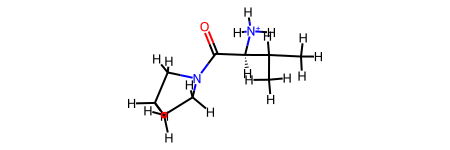

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

ms = [x for x in Chem.SDMolSupplier('/home/glandrum/Datasets/AZ_alignment/P27487.sdf',removeHs=False) if x is not None]
len(ms)

ref = ms.pop(0)
ref

Generate 100 conformers of each of the molecules to align:

In [2]:
ps = rdDistGeom.srETKDGv3()
ps.randomSeed = 0xa100f
ps.numThreads = 8
for m in ms:
    rdDistGeom.EmbedMultipleConfs(m,100,ps)

In [3]:
len(ms)

37

In [4]:
import copy
ms_save = copy.deepcopy(ms)

In [5]:
ms = copy.deepcopy(ms_save)

Look at the two molecules to align, just to see where we are starting.

In [6]:
import py3Dmol
p = py3Dmol.view(width=400, height=400)
IPythonConsole.addMolToView(ref,p)
IPythonConsole.addMolToView(ms[0],p)
p.zoomTo()
p.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Do an alignment and look at the results.

The two scores are: shape Tanimoto, "color" (=feature) Tanimoto

In [7]:
from rdkit.Chem import rdShapeAlign
tpl = rdShapeAlign.AlignMol(ref,ms[0])
print(tpl)


p = py3Dmol.view(width=400, height=400)
IPythonConsole.addMolToView(ref,p)
IPythonConsole.addMolToView(ms[0],p)
p.zoomTo()
p.show()


(0.4333876003130784, 0.03657366774970186)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Find the conformer from each molecule that provides the highest "color" score and see how long that takes.

In [12]:
import time

t1 = time.time()
refShape = rdShapeAlign.PrepareConformer(ref)

nAligns = 0
bestScores = []
for m in ms:
    best = -1e8
    bestConf = -1
    for conf in m.GetConformers():
        nAligns += 1
        shapeTani,colorTani = rdShapeAlign.AlignMol(refShape,m,probeConfId=conf.GetId())
        if colorTani > best:
            best = colorTani
            bestConf = conf.GetId()
    bestScores.append((best,bestConf))
t2 = time.time()
print(f'{t2-t1:.2f} seconds for {nAligns} alignments, {(t2-t1)/nAligns:.2g}s per alignment')

2.51 seconds for 3700 alignments, 0.00068s per alignment


Look at the best alignment for one of the molecules:

In [14]:
whichMol = 1
bestConf = bestScores[whichMol][1]

print(bestScores[whichMol])
p = py3Dmol.view(width=400, height=400)
IPythonConsole.addMolToView(ref,p)
IPythonConsole.addMolToView(ms[whichMol],p,confId=bestConf)
p.zoomTo()
p.show()

(0.343586129348326, 5)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Which of the molecules produced the highest score?

In [15]:
order = sorted([(tpl,i) for i,tpl in enumerate(bestScores)],reverse=True)
order[:5]

[((0.41623472182088234, 53), 10),
 ((0.38375118479238873, 83), 14),
 ((0.343586129348326, 5), 1),
 ((0.3286720498960583, 87), 17),
 ((0.305952661317346, 20), 13)]

In [17]:
whichMol = 10
bestConf = bestScores[whichMol][1]

print(bestScores[whichMol])
p = py3Dmol.view(width=400, height=400)
IPythonConsole.addMolToView(ref,p)
IPythonConsole.addMolToView(ms[whichMol],p,confId=bestConf)
p.zoomTo()
p.show()

(0.41623472182088234, 53)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## More multi-threading

In [45]:
ms = [x for x in Chem.SDMolSupplier('./data/platinum_dataset_2017_01.sdf')]
len(ms)

4548

### MolStandardize
ongoing, started in v2023.09.3

In [42]:
from rdkit.Chem.MolStandardize import rdMolStandardize

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

In [48]:
%timeit nms = [Chem.Mol(m) for m in ms]; [rdMolStandardize.Normalize(m) for m in nms]


1.64 s ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%timeit nms = [Chem.Mol(m) for m in ms]; [rdMolStandardize.NormalizeInPlace(m) for m in nms]

1.17 s ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit nms = [Chem.Mol(m) for m in ms]; rdMolStandardize.NormalizeInPlace(ms,numThreads=4)

212 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


There are `InPlace` versions of many of the functions in `rdMolStandardize`

### Fingerprint generation
v2023.09.3

In [36]:
from rdkit.Chem import rdFingerprintGenerator
fpg = rdFingerprintGenerator.GetMorganGenerator()

In [37]:
%timeit [fpg.GetFingerprint(m) for m in ms]

249 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There's are new bulk functions to calculate fingerprints for multiple molecules in a single call:

In [38]:
%timeit fpg.GetFingerprints(ms)

239 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
fpg.Get

The functions `GetCountFingerprints()`, `GetSparseFingerprints()`, and `GetSparseCountFingerprints()` are also there

These can also use multiple threads:

In [39]:
%timeit fpg.GetFingerprints(ms,numThreads=4)

62.6 ms ± 124 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### rdMolProcessing
v2024.09.1 (potentially)

Efficiently generating fingerprints for a bunch of molecules without having to load all the molecules into memory at once.

Here's the "standard" way to do it:
```
In [16]: fpg = rdFingerprintGenerator.GetMorganGenerator()

In [19]: %timeit suppl = Chem.SmilesMolSupplier('../Regress/Data/znp.50k.smi');fps = [fpg.GetFingerprint(m) for m in suppl if m is not None]
8.22 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

Here's how it works with the new code:

```
In [27]: opts = rdMolProcessing.SupplierOptions()

In [28]: opts.delimiter = ' '

In [29]: %timeit fps = rdMolProcessing.GetFingerprintsForMolsInFile('../Regress/Data/znp.50k.smi',options=opts)
1.3 s ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

This works for quite large datasets; here's an example of generating fingerprints for the 2.3 million compounds in ChEMBL31:
```
In [44]: t1 = time.time(); fps = rdMolProcessing.GetFingerprintsForMolsInFile('/scratch/Data/ChEMBL/chembl_31.sdf.gz'); t2=time.time(); print(f'{t2-t1:.2f}')
74.72

In [45]: len(fps)
Out[45]: 2304875
```
Notice that I didn't have to do anything special to deal with the compressed input file.

## Rascal MCES implementation
(2023.09)

Developer David Cosgrove, funded by Glysade

The Rascal (Rapid Similarity CALculation) algorithm of Raymond et al. is a rapid way of finding Maximum Common Edge Subgraphs, optimised for chemical structures. It finds the bonds that are in common between 2 structures, rather than the more normal matching atoms. The result is usually, but not always, the same. 

Unlike the rdFMCS approach, Rascal:
- can produce a fragmented MCES if relevant.
- only works on pairs of molecules


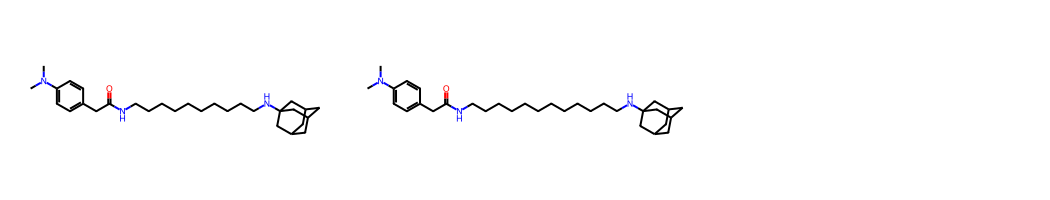

In [86]:
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

from rdkit.Chem import rdRascalMCES

mol1 = Chem.MolFromSmiles('CN(C)c1ccc(CC(=O)NCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1')
mol2 = Chem.MolFromSmiles('CN(C)c1ccc(CC(=O)NCCCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1')
Draw.MolsToGridImage((mol1,mol2),subImgSize=(350,200))

In [87]:
results = rdRascalMCES.FindMCES(mol1, mol2)
res = results[0]
print(f'MCES SMARTS : {res.smartsString}')
print(f'Matching Bonds : {res.bondMatches()}')
print(f'Matching Atoms : {res.atomMatches()}')

MCES SMARTS : CN(-C)-c1:c:c:c(-CC(=O)-NCCCCCCCCCC):c:c:1.NC12CC3CC(-C1)-CC(-C2)-C3
Matching Bonds : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35), (34, 36), (35, 37), (36, 38)]
Matching Atoms : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35)]


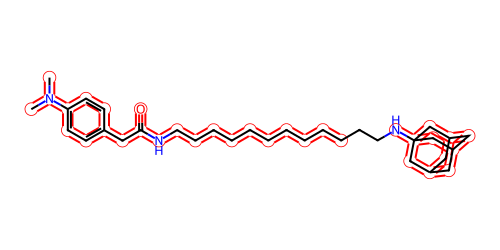

In [88]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def extractHighlights(res):
    bondHighlights1 = {}
    bondHighlights2 = {}
    for bondPair in res.bondMatches():
        bondHighlights1[bondPair[0]] = [(1.0, 0.0, 0.0)]
        bondHighlights2[bondPair[1]] = [(1.0, 0.0, 0.0)]
    atomHighlights1 = {}
    atomHighlights2 = {}
    for atomPair in res.atomMatches():
        atomHighlights1[atomPair[0]] = [(1.0, 0.0, 0.0)]
        atomHighlights2[atomPair[1]] = [(1.0, 0.0, 0.0)]
    return bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2

def drawMCESMatch(mol1, bondHighlights, atomHighlights):    
    d = rdMolDraw2D.MolDraw2DSVG(500, 250)
    d.drawOptions().fillHighlights = False
    d.drawOptions().multiColourHighlightStyle = Draw.MultiColourHighlightStyle.Lasso
    hRads = {}
    hLwMult = {}
    d.DrawMoleculeWithHighlights(mol1, "", atomHighlights, bondHighlights, hRads, hLwMult, -1)
    d.FinishDrawing()
    return d

bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2 = extractHighlights(res)
d = drawMCESMatch(mol2, bondHighlights2, atomHighlights2)
SVG(d.GetDrawingText())


### MCES Clustering

In [123]:
from rdkit import RDConfig
import os
from pathlib import Path
cdk2_file = Path(RDConfig.RDContribDir) / 'Fastcluster' / 'cdk2.smi'
suppl = Chem.SmilesMolSupplier(str(cdk2_file), '\t', 1, 0, False)
mols = [mol for mol in suppl]
print(f'{len(mols)} molecules')
clusters = rdRascalMCES.RascalCluster(mols)
print(clusters)

47 molecules
[[3, 4, 1, 2, 0, 28, 29], [25, 26, 38, 24, 46, 39, 27], [6, 34, 35, 7, 5, 44], [36, 44], [13, 14], [19, 20], [21, 22], [16, 18, 17, 10, 23, 32, 30, 15, 33, 31, 9, 37, 42, 12, 11, 8, 40, 41, 43, 45]]


In [124]:
import ipywidgets as widgets
from ipywidgets import interact,fixed
from IPython.display import SVG,Image

@interact(whichCluster=range(len(clusters)))
def showCluster(whichCluster):
    return Draw.MolsToGridImage([mols[x] for x in clusters[whichCluster]],molsPerRow=4)

interactive(children=(Dropdown(description='whichCluster', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), Output(…

In [125]:
%timeit clusters = rdRascalMCES.RascalCluster(mols)

80.2 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [126]:
clusters = rdRascalMCES.RascalButinaCluster(mols)
print(clusters)

[[25, 26, 38, 24, 27, 46], [6, 34, 5, 35, 44, 7], [4, 3, 1, 2, 0, 28], [22, 21], [20, 19], [14, 13], [45], [43], [42], [41], [40], [39], [37], [36], [33], [32], [31], [30], [29], [23], [18], [17], [16], [15], [12], [11], [10], [9], [8]]


In [127]:
import ipywidgets as widgets
from ipywidgets import interact,fixed
from IPython.display import SVG,Image

@interact(whichCluster=range(len(clusters)))
def showCluster(whichCluster):
    return Draw.MolsToGridImage([mols[x] for x in clusters[whichCluster]],molsPerRow=4)

interactive(children=(Dropdown(description='whichCluster', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

In [128]:
%timeit clusters = rdRascalMCES.RascalCluster(mols)

80.2 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Misc

### smaller pickles
v2023.09.1


In [135]:
import pickle
ms = [x for x in Chem.SDMolSupplier('./data/platinum_dataset_2017_01.sdf')]
v = Chem.GetDefaultPickleProperties()
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
pkl = pickle.dumps(ms)
print(len(pkl))
Chem.SetDefaultPickleProperties(v)

12947548


That was 15414496 before, so we're about 16% smaller.

### Mol.HasQuery()
v2023.09.1

It's now possible to check whether or not a molecule has query features on any of the atoms or bonds. This can be useful for things like deciding whether to generate SMILES or SMARTS

In [140]:
m = Chem.MolFromSmiles('CCCO')
m2 = Chem.RWMol(m)
m2.ReplaceAtom(3,Chem.AtomFromSmarts('[OD1]'))
print(m.HasQuery(),m2.HasQuery())

False True


### Writing SMARTS queries to V3K mol blocks
v2023.09.3

In [6]:
m = Chem.MolFromSmarts('[C,N,O]C[#6]*[$(C(=O)O)]')

In [4]:
mb = Chem.MolToV3KMolBlock(m)
print(mb)


     RDKit          2D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 5 4 1 0 0
M  V30 BEGIN ATOM
M  V30 1 [C,N,O] 0.000000 0.000000 0.000000 0
M  V30 2 C 1.299038 0.750000 0.000000 0
M  V30 3 C 2.598076 -0.000000 0.000000 0
M  V30 4 * 3.897114 0.750000 0.000000 0
M  V30 5 * 5.196152 -0.000000 0.000000 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 6 1 2
M  V30 2 6 2 3
M  V30 3 6 3 4
M  V30 4 6 4 5
M  V30 END BOND
M  V30 BEGIN SGROUP
M  V30 1 DAT 0 ATOMS=(1 5) QUERYTYPE=SMARTSQ QUERYOP== -
M  V30 FIELDDATA="[$(C(=O)O)]"
M  V30 END SGROUP
M  V30 END CTAB
M  END



In [5]:
m2 = Chem.MolFromMolBlock(mb)
print(Chem.MolToSmarts(m2))

[#6,#7,#8][#6][#6]*[$(C(=O)O)]


### Atom.HasValenceViolation() function
v2023.09.5

Developer: Chris Von Bargen

In [53]:
m = Chem.MolFromSmiles('CCO(C)C',sanitize=False)
m.UpdatePropertyCache(False)
for atom in m.GetAtoms():
    print(atom.GetIdx(),atom.GetSymbol(),atom.HasValenceViolation())

0 C False
1 C False
2 O True
3 C False
4 C False


### Sanitizing reaction components
v2023.09.5 

In [55]:
from rdkit.Chem import rdChemReactions

rxn = rdChemReactions.ReactionFromSmarts("C1=CC=CC=C1>CN(=O)=O>C1=CC=CC=N1", useSmiles=True)
rxn.GetReactantTemplate(0).Debug()

Atoms:
	0 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	1 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	2 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	3 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	4 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
	5 6 C chg: 0  deg: 2 exp: N/A imp: N/A hyb: 
Bonds:
	0 0->1 order: 2
	1 1->2 order: 1
	2 2->3 order: 2
	3 3->4 order: 1
	4 4->5 order: 2
	5 5->0 order: 1


In [56]:
rdChemReactions.SanitizeRxnAsMols(rxn)
rxn.GetReactantTemplate(0).Debug()

Atoms:
	0 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
Bonds:
	0 0->1 order: a conj?: 1 aromatic?: 1
	1 1->2 order: a conj?: 1 aromatic?: 1
	2 2->3 order: a conj?: 1 aromatic?: 1
	3 3->4 order: a conj?: 1 aromatic?: 1
	4 4->5 order: a conj?: 1 aromatic?: 1
	5 5->0 order: a conj?: 1 aromatic?: 1


### Molzip now supports the output of R-group decomposition
v2024.03.1

Developer: Brian Kelley

First a reminder about what molzip does:

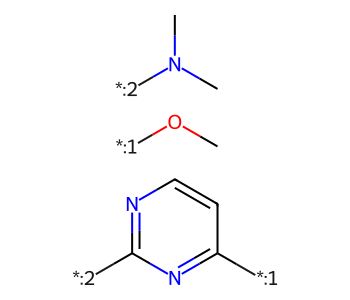

In [6]:
IPythonConsole.molSize = 350,300
from rdkit.Chem import rdRGroupDecomposition
sample = Chem.MolFromSmiles('[*:1]c1nc([*:2])ncc1.CO[*:1].[*:2]N(C)C')
sample


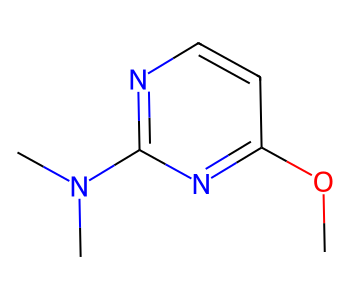

In [7]:
Chem.molzip(sample)

Here's how it works with R-group decomposition:

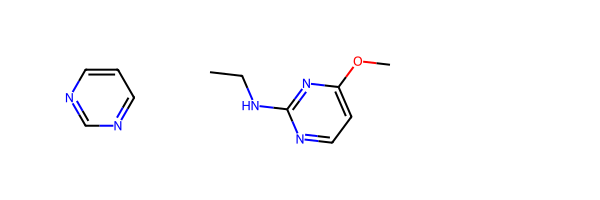

In [8]:
core = Chem.MolFromSmiles('c1ncncc1')
mol = Chem.MolFromSmiles('c1nc(NCC)nc(OC)c1')
Draw.MolsToGridImage([core,mol])

In [12]:
rgd,_ = rdRGroupDecomposition.RGroupDecompose(core,[mol])
rgd[0]

{'Core': <rdkit.Chem.rdchem.Mol at 0x7e7c1d96a6c0>,
 'R1': <rdkit.Chem.rdchem.Mol at 0x7e7c1d96a490>,
 'R2': <rdkit.Chem.rdchem.Mol at 0x7e7c1d96a9d0>}

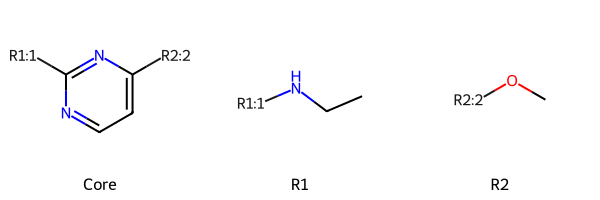

In [15]:
Draw.MolsToGridImage(rgd[0].values(),legends=rgd[0].keys())

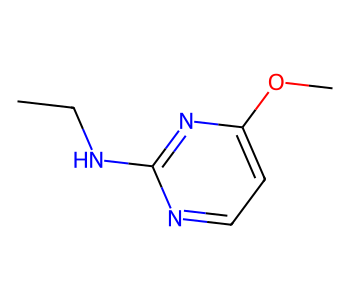

In [16]:
nmol = Chem.molzip(rgd[0])
nmol

This makes it easy to enumerate all compounds covered by the R-groups of a set of compounds

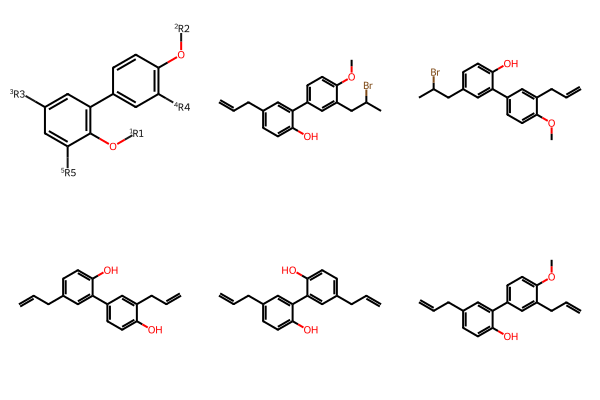

In [17]:
mols = [x for x in Chem.ForwardSDMolSupplier('/localhome/glandrum/RDKit_git/Code/GraphMol/RGroupDecomposition/test_data/jm200186n.excerpt.sdf')]
Draw.MolsToGridImage(mols[:6])

In [83]:
core = mols.pop(0)

In [94]:
rgd,mismatch = rdRGroupDecomposition.RGroupDecompose(core,mols,asRows=False)
print(len(mismatch),'mismatches')
matched_mols = [mols[x] for x in range(len(mols)) if x not in mismatch]
rgd

1 mismatches


[09:45:46] No core matches


{'Core': [<rdkit.Chem.rdchem.Mol at 0x7e7c1d4f4740>,
 'R2': [<rdkit.Chem.rdchem.Mol at 0x7e7c1d3dc5f0>,
 'R3': [<rdkit.Chem.rdchem.Mol at 0x7e7c1d3dc6d0>,
 'R4': [<rdkit.Chem.rdchem.Mol at 0x7e7c1d3dc3c0>,
 'R6': [<rdkit.Chem.rdchem.Mol at 0x7e7c1d3dc900>,
  <rdkit.Chem.rdchem.Mol at 0x7e7c1d3dcb30>]}

Get the unique entries:

In [95]:
for k in ('Core','R2','R3','R4','R6'):
    seen = set()
    unique = []
    for m in rgd[k]:
        smi = Chem.MolToSmiles(m)
        if smi in seen:
            continue
        unique.append(m)
        seen.add(smi)
    rgd[k] = unique
    print(k,len(seen))

Core 1
R2 2
R3 2
R4 2
R6 2


Form all possible combinations

In [96]:
sets = []
for core in rgd['Core']:
    for r2 in rgd['R2']:
        for r3 in rgd['R3']:
            for r4 in rgd['R4']:
                for r6 in rgd['R6']:
                    sets.append({'Core':core,'R2':r2,'R3':r3,'R4':r4,'R6':r6})

len(sets)

16

Now form the molecules and filter out the ones we've already seen:

starting with 5 original molecules and 16 candidates.
11


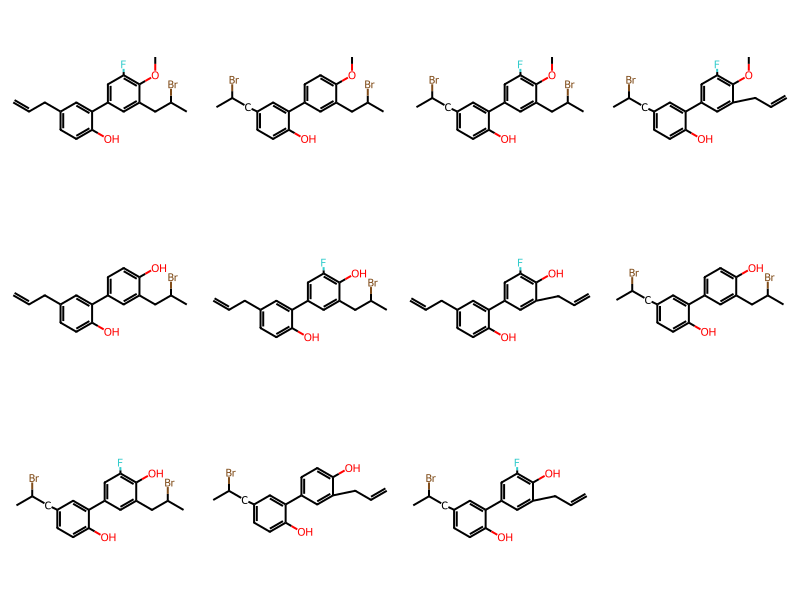

In [98]:
new_mols = []
oseen = {Chem.MolToSmiles(m) for m in matched_mols}
print(f'starting with {len(oseen)} original molecules and {len(sets)} candidates.')
nseen = set()
for ts in sets:
    mol = Chem.RemoveHs(Chem.molzip(ts))
    smi = Chem.MolToSmiles(mol)
    if smi in nseen or smi in oseen:
        continue
    new_mols.append(mol)
    nseen.add(smi)
print(len(new_mols))

Draw.MolsToGridImage(new_mols,molsPerRow=4)
    

### DCLV descriptors
v2024.03.1

Developer: Rachael Pirie


Rachael will talk about this during the UGM

In [63]:
from rdkit.Chem import rdMolDescriptors

from rdkit.Chem import rdDistGeom
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xa100f

mol = Chem.AddHs(Chem.MolFromSmiles('c1nc(CCC)ncc1'))
rdDistGeom.EmbedMolecule(mol,ps)

d = rdMolDescriptors.DoubleCubicLatticeVolume(mol,isProtein=False)
print(d.GetSurfaceArea())
print(d.GetVolume())
print(d.GetVDWVolume())


272.40116223453464
373.0638698439309
124.90274420206592


### ReplaceAtomWithQueryAtom()
v2024.03.3

Developer: Dave Cosgrove

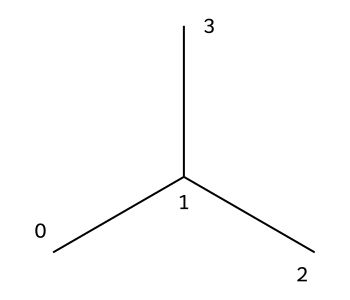

In [107]:
IPythonConsole.drawOptions.addAtomIndices = True
m = Chem.MolFromSmiles('CC(C)C')
m

In [108]:
q = Chem.MolFromSmiles('C')
m.GetSubstructMatches(q)

((0,), (1,), (2,), (3,))

In [109]:
from rdkit.Chem import rdqueries
qry = rdqueries.ExplicitDegreeEqualsQueryAtom(3)

# start by replacing the normal atom with a query atom, the new query atom is returned:
qatm = rdqueries.ReplaceAtomWithQueryAtom(q,q.GetAtomWithIdx(0))
# and now modify the query on that atom:
qatm.ExpandQuery(qry, Chem.CompositeQueryType.COMPOSITE_AND)

m.GetSubstructMatches(q)

((1,),)

### The uncharger can now be set to only add protons, not hydrides
v2024.03.4

Developer: Riccardo Vianello

In [111]:
from rdkit.Chem.MolStandardize import rdMolStandardize

m1 = Chem.MolFromSmiles('CC[CH2+]')
m2 = Chem.MolFromSmiles('CC[O-]')

Default behavior:

In [112]:
uc = rdMolStandardize.Uncharger()
print(Chem.MolToSmiles(uc.uncharge(m1)))
print(Chem.MolToSmiles(uc.uncharge(m2)))

CCC
CCO


[09:38:09] Running Uncharger
[09:38:09] Removed positive charge.
[09:38:09] Running Uncharger
[09:38:09] Removed negative charge.


In [113]:
uc = rdMolStandardize.Uncharger(protonationOnly=True)
print(Chem.MolToSmiles(uc.uncharge(m1)))
print(Chem.MolToSmiles(uc.uncharge(m2)))

[CH2+]CC
CCO


[09:38:27] Running Uncharger
[09:38:27] Running Uncharger
[09:38:27] Removed negative charge.


### New convenience functions
v2024.03.3, v2024.03.4

NeedsHs(), AtomHasConjugatedBond()

In [99]:
m = Chem.MolFromSmiles('CCO')
mh = Chem.AddHs(m)
print(Chem.NeedsHs(m),Chem.NeedsHs(mh))

True False


In [100]:
print(Chem.NeedsHs(Chem.MolFromSmiles('ClC(Cl)(Cl)Cl')))

False


In [104]:
m = Chem.MolFromSmiles('CC=CC=O')
ri = m.GetRingInfo()
for atom in m.GetAtoms():
    print(atom.GetSymbol(),Chem.AtomHasConjugatedBond(atom))

C False
C True
C True
C True
O True


MolToV2KMolBlock()

`MolToMolBlock()` generates a v2K mol block by default, but some molecule features will cause a v3K mol block to be generated in order to avoid information loss.

`MolToV2KMolBlock()` will always generate a v2K mol block, even if that means that information is lost.

It will also be useful for the point in the future that we switch over to producing v3k mol blocks by default.

In [120]:
m = Chem.MolFromSmiles('C[C@H](F)Cl |o1:1|')
print(Chem.MolToMolBlock(m))


     RDKit          2D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 4 3 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C 0.000000 0.000000 0.000000 0
M  V30 2 C 1.299038 0.750000 0.000000 0
M  V30 3 F 2.598076 -0.000000 0.000000 0
M  V30 4 Cl 1.299038 2.250000 0.000000 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 2 1 CFG=1
M  V30 2 1 2 3
M  V30 3 1 2 4
M  V30 END BOND
M  V30 BEGIN COLLECTION
M  V30 MDLV30/STEREL1 ATOMS=(1 2)
M  V30 END COLLECTION
M  V30 END CTAB
M  END



In [121]:
print(Chem.MolToV2KMolBlock(m))


     RDKit          2D

  4  3  0  0  0  0  0  0  0  0999 V2000
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.2990    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.5981   -0.0000    0.0000 F   0  0  0  0  0  0  0  0  0  0  0  0
    1.2990    2.2500    0.0000 Cl  0  0  0  0  0  0  0  0  0  0  0  0
  2  1  1  1
  2  3  1  0
  2  4  1  0
M  END



## New supported file formats

### MRV reading and writing
(2023.09)

Developer: Tad Hurst

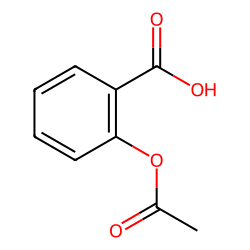

In [5]:
from rdkit import RDConfig
import os
IPythonConsole.molSize = 250,250

fn = os.path.join(RDConfig.RDBaseDir,'Code','GraphMol','MarvinParse','test_data','aspirin.mrv')
mol = Chem.MolFromMrvFile(fn)
mol


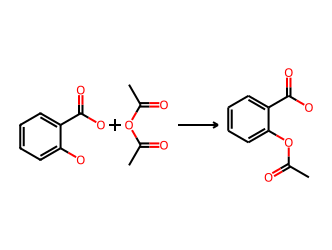

In [6]:
from rdkit.Chem import rdChemReactions
fn = os.path.join(RDConfig.RDBaseDir,'Code','GraphMol','MarvinParse','test_data','aspirineSynthesisWithAttributes.mrv')
rxn = rdChemReactions.ReactionFromMrvFile(fn)
rxn

We can write MRV as well:

In [7]:
mrv = Chem.MolToMrvBlock(mol,1,-1,1,1)
print(mrv[:1000])

<?xml version="1.0" encoding="windows-1252"?>
<cml xmlns="http://www.chemaxon.com" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.chemaxon.com http://www.chemaxon.com/marvin/schema/mrvSchema_20_20_0.xsd">
	<MDocument>
		<MChemicalStruct>
			<molecule molID="m1">
				<atomArray>
					<atom id="a1" elementType="C" x2="8.2077" y2="1.9251"/>
					<atom id="a2" elementType="C" x2="6.874" y2="1.1551"/>
					<atom id="a3" elementType="C" x2="6.874" y2="-0.3847"/>
					<atom id="a4" elementType="C" x2="8.2077" y2="-1.1545"/>
					<atom id="a5" elementType="C" x2="9.5415" y2="-0.3847"/>
					<atom id="a6" elementType="C" x2="9.5415" y2="1.1551"/>
					<atom id="a7" elementType="C" x2="10.8752" y2="1.9251"/>
					<atom id="a8" elementType="O" x2="10.8752" y2="3.4651"/>
					<atom id="a9" elementType="O" x2="12.2089" y2="1.1551"/>
					<atom id="a10" elementType="O" x2="10.8752" y2="-1.1549"/>
					<atom id="a11" elementType="C" x2="10.875" y2="-2.6949"/>
			

In [8]:
mrv = rdChemReactions.ReactionToMrvBlock(rxn,1)
print(mrv[:1000])

<?xml version="1.0" encoding="windows-1252"?>
<cml xmlns="http://www.chemaxon.com" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.chemaxon.com http://www.chemaxon.com/marvin/schema/mrvSchema_20_20_0.xsd">
	<MDocument>
		<MChemicalStruct>
			<reaction>
				<reactantList>
					<molecule molID="m1">
						<atomArray>
							<atom id="a1" elementType="C" x2="-10.8752" y2="1.4315"/>
							<atom id="a2" elementType="C" x2="-12.2089" y2="0.6615"/>
							<atom id="a3" elementType="C" x2="-12.2089" y2="-0.8783"/>
							<atom id="a4" elementType="C" x2="-10.8752" y2="-1.6483"/>
							<atom id="a5" elementType="C" x2="-9.5415" y2="-0.8783"/>
							<atom id="a6" elementType="C" x2="-9.5415" y2="0.6615"/>
							<atom id="a7" elementType="C" x2="-8.2077" y2="1.4315"/>
							<atom id="a8" elementType="O" x2="-8.2077" y2="2.9715"/>
							<atom id="a9" elementType="O" x2="-6.874" y2="0.6615"/>
							<atom id="a10" elementType="O" x2="-8.2077" y2="-1.6483"/

## Jupyter integration improvements

### Draw.MolsMatrixToGridImage
(2023.09)

Developer: Jeremy Monat

This new function allows molecules to be drawn in a grid with gaps.

In [9]:
with Chem.ForwardSDMolSupplier('./data/RGD_sets/data/jm6b00372.sdf') as suppl:
    mols = [x for x in suppl if x is not None]
len(mols)

78

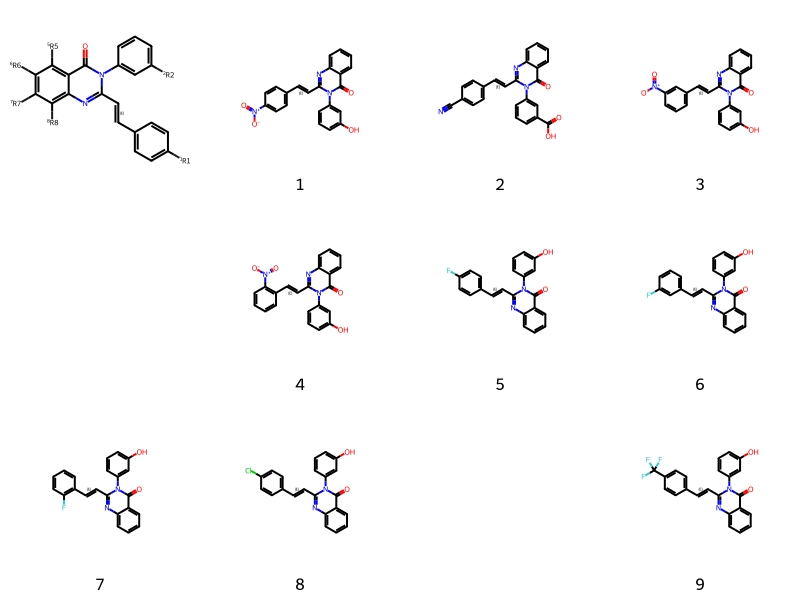

In [10]:
matrix = [[mols[0],mols[1],mols[2],mols[3]],
          [None,mols[4],mols[5],mols[6]],
          [mols[7],mols[8],None,mols[9]],
         ]
namesMatrix = []
for row in matrix:
    nrow = []
    for entry in row:
        if entry is None:
            nrow.append('')
        else:
            nrow.append(entry.GetProp('_Name'))
    namesMatrix.append(nrow)
Draw.MolsMatrixToGridImage(matrix,legendsMatrix=namesMatrix)


This works outside of the notebook as well.

## MolDraw2D improvements
(ongoing, this example shows features added for 2021.09, 2022.03, and 2022.09)

This is one area of the code which is being updated and tweaked in more or less every RDKit release.

Descriptions of most of the drawing options can be found here:
https://greglandrum.github.io/rdkit-blog/posts/2023-05-26-drawing-options-explained.html



## MolStandardize improvements
(2023.09 release)

Many of the operations can now modify a molecule in place instead of making a copy.

Here's a silly example:

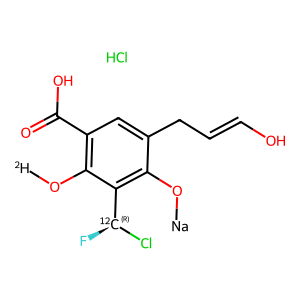

In [23]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
# the standardization code is verbose... disable that
RDLogger.DisableLog('rdApp.info')
IPythonConsole.molSize = 300,300
msm1 = Chem.MolFromSmiles('[Na]Oc1c([12C@H](F)Cl)c(O[2H])c(C(=O)O)cc1CC=CO.Cl')
msm1

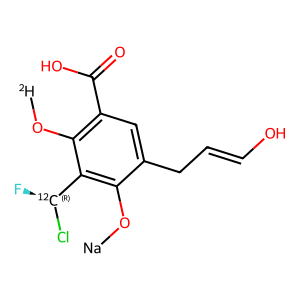

In [24]:
stripped = rdMolStandardize.RemoveFragments(msm1)
stripped

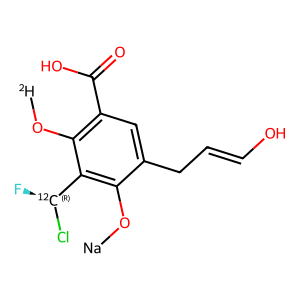

In [25]:
cp = Chem.Mol(msm1)
rdMolStandardize.RemoveFragmentsInPlace(cp)
cp


This can have a significant performance impact:

In [26]:
%timeit cp = Chem.Mol(msm1);rdMolStandardize.Normalize(cp)

892 µs ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%timeit cp = Chem.Mol(msm1);rdMolStandardize.NormalizeInPlace(cp)

731 µs ± 8.78 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
RDLogger.EnableLog('rdApp.info')


## Making it easy to calculate all 3D descriptors
(2023.09)
Developer: Rachael Pirie

In [3]:
from rdkit.Chem import rdDistGeom
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xbaff1ed
doravirine = Chem.AddHs(Chem.MolFromSmiles('Cn1c(n[nH]c1=O)Cn2ccc(c(c2=O)Oc3cc(cc(c3)Cl)C#N)C(F)(F)F'))
rdDistGeom.EmbedMolecule(doravirine,ps)

0

In [4]:
from rdkit.Chem import Descriptors3D
descrs = Descriptors3D.CalcMolDescriptors3D(doravirine)
descrs

{'PMI1': 1988.5469756200407,
 'PMI2': 6460.483759072387,
 'PMI3': 7894.0517768796535,
 'NPR1': 0.25190447590477677,
 'NPR2': 0.818398959327079,
 'RadiusOfGyration': 4.380993616699458,
 'InertialShapeFactor': 0.0004115562616125261,
 'Eccentricity': 0.9677521041150671,
 'Asphericity': 0.4262755643899801,
 'SpherocityIndex': 0.15802941947335028,
 'PBF': 0.7991109081294012}

## Beilstein generics
(2022.03 release, extended in 2023.09)

Developers: Greg Landrum, Jonathan Bisson

Supported generics (from the RDKit book):

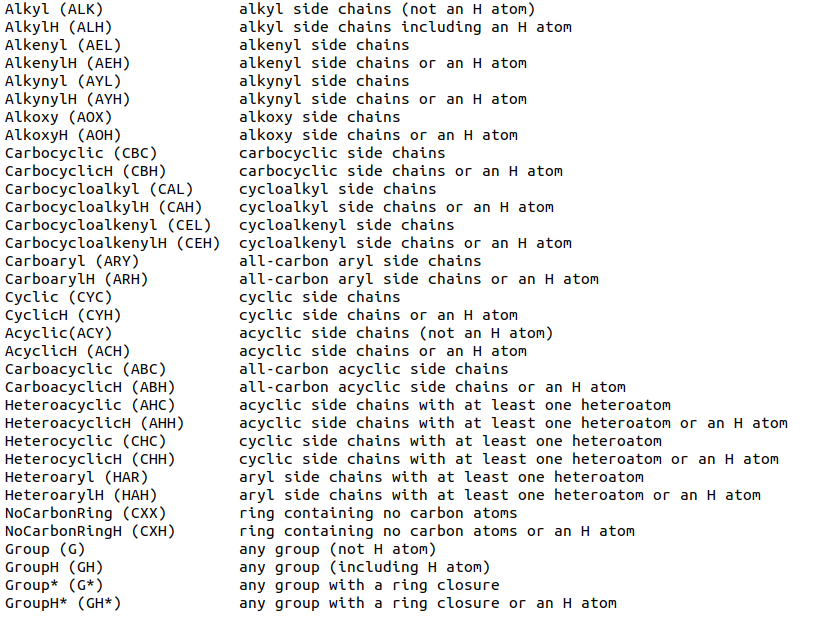



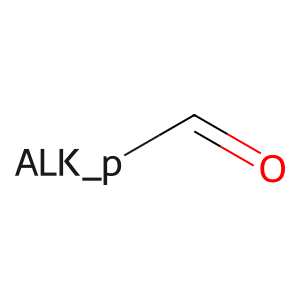

In [29]:
q = Chem.MolFromSmarts('O=C-* |$;;ALK_p$|')
q

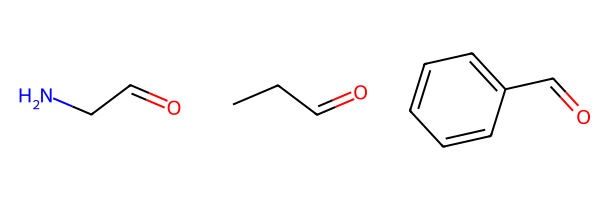

In [30]:
ms = [Chem.MolFromSmiles(x) for x in ('O=CCN','CCC=O','c1ccccc1C=O')]
Draw.MolsToGridImage(ms)

In [31]:
[m.HasSubstructMatch(q) for m in ms]

[True, True, True]

In [32]:
Chem.SetGenericQueriesFromProperties(q)
ps = Chem.SubstructMatchParameters()
ps.useGenericMatchers = True
[m.HasSubstructMatch(q,ps) for m in ms]

[False, True, False]

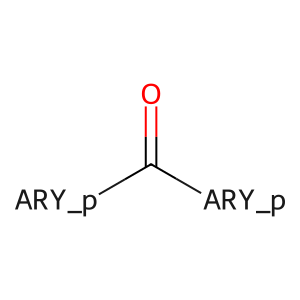

In [33]:
q = Chem.MolFromSmarts('O=C(-*)(-*) |$;;ARY_p;ARY_p$|')
q

In [34]:
Chem.SetGenericQueriesFromProperties(q)
ps = Chem.SubstructMatchParameters()
ps.useGenericMatchers = True
[m.HasSubstructMatch(q,ps) for m in ms]

[False, False, False]

These work with SubstructLibraries too

In [35]:
import pickle
with open('./data/demo_ssslib.pkl','rb') as inf:
    slib = pickle.load(inf)
slib

1000 results


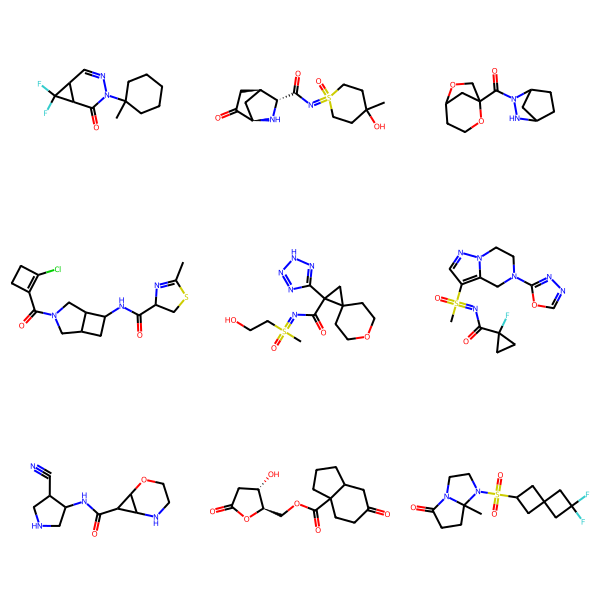

In [36]:
mids = slib.GetMatches(q)
print(f'{len(mids)} results')
ms = [slib.GetMolHolder().GetMol(x) for x in mids[:9]]
Draw.MolsToGridImage(ms)

25 results


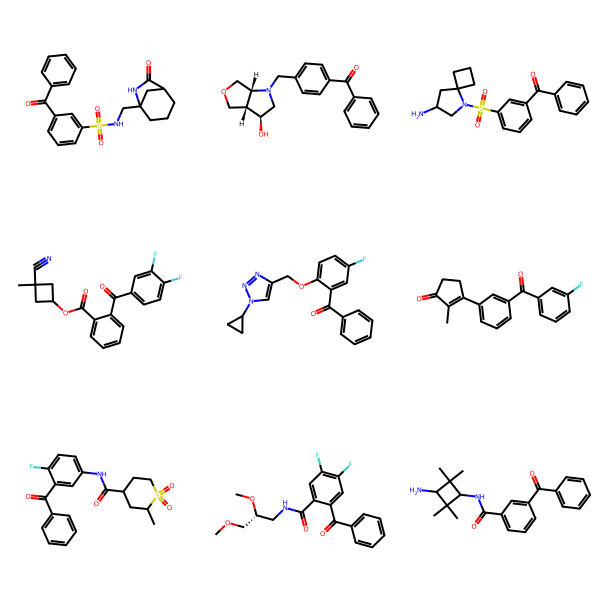

In [37]:
mids = slib.GetMatches(q,ps)
print(f'{len(mids)} results')
ms = [slib.GetMolHolder().GetMol(x) for x in mids[:9]]
Draw.MolsToGridImage(ms)

## Generalized substructure search
ongoing, first release in v2023.09.1 

Developers: Greg and Gareth Jones


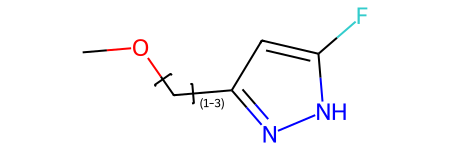

In [8]:
qry = Chem.MolFromSmiles('COCc1n[nH]c(F)c1 |LN:2:1.3|')
qry

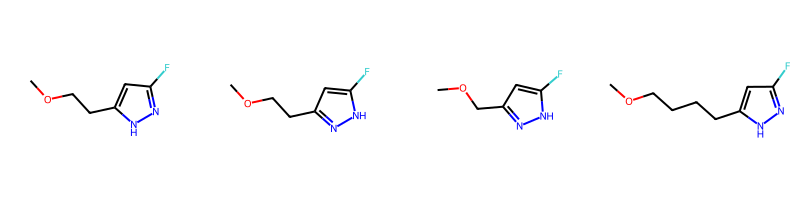

In [9]:
mols = [Chem.MolFromSmiles(smi) for smi in ('COCCc1[nH]nc(F)c1','COCCc1n[nH]c(F)c1','COCc1n[nH]c(F)c1','COCCCCc1[nH]nc(F)c1',)]
Draw.MolsToGridImage(mols,molsPerRow=4)

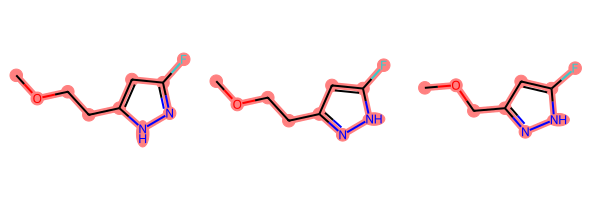

In [10]:
from rdkit.Chem import rdGeneralizedSubstruct
xqm = rdGeneralizedSubstruct.CreateExtendedQueryMol(qry)
matches = [rdGeneralizedSubstruct.MolGetSubstructMatch(m,xqm) for m in mols]
Draw.MolsToGridImage([m for (m,match) in zip(mols,matches) if match],highlightAtomLists = [m for m in matches if m])

### Generalized substructure search and RGD
2023.09.1

Developer: Gareth Jones

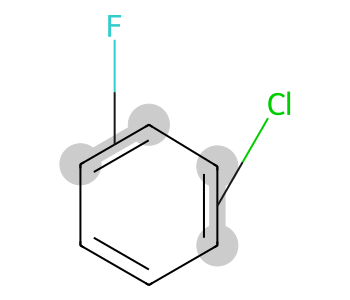

In [141]:
core = Chem.MolFromMolBlock('''
  Mrv2008 08242317002D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 10 8 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -4.4167 11.04 0 0
M  V30 2 C -5.7503 10.27 0 0
M  V30 3 C -5.7503 8.6883 0 0
M  V30 4 C -4.4167 7.9183 0 0
M  V30 5 C -3.083 8.6883 0 0
M  V30 6 C -3.083 10.2283 0 0
M  V30 7 * -5.0835 10.655 0 0
M  V30 8 F -5.0835 12.965 0 0
M  V30 9 * -3.083 9.4583 0 0
M  V30 10 Cl -1.928 11.4589 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 8 ENDPTS=(2 1 2) ATTACH=ANY
M  V30 8 1 9 10 ENDPTS=(2 5 6) ATTACH=ANY
M  V30 END BOND
M  V30 END CTAB
M  END''')
core

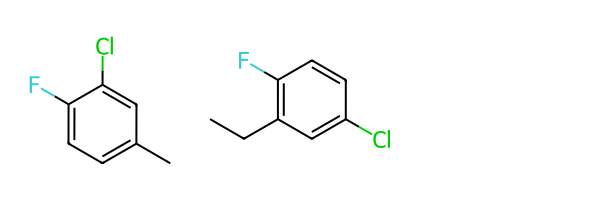

In [142]:
ms = [Chem.MolFromSmiles(s) for s in ("CC1=CC=C(F)C(Cl)=C1","CCC1=C(F)C=CC(Cl)=C1")]
Draw.MolsToGridImage(ms)

In [146]:
from rdkit.Chem import rdRGroupDecomposition
ps = rdRGroupDecomposition.RGroupDecompositionParameters()
ps.onlyMatchAtRGroups = False
ps.doEnumeration = True
rgd,_ = rdRGroupDecomposition.RGroupDecompose([core],ms,asSmiles=True,options=ps)
rgd

[{'Core': 'Fc1ccc([*:2])cc1Cl', 'R2': 'C[*:2]'},
 {'Core': 'Fc1ccc(Cl)cc1[*:1]', 'R1': 'CC[*:1]'}]

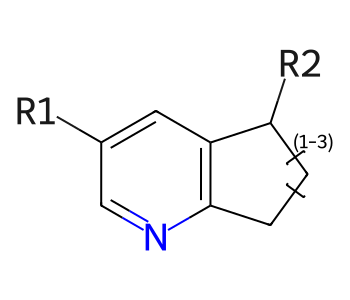

In [148]:
core = Chem.MolFromSmiles('[*]C1=CC2=C(CCC2[*])N=C1 |$R1;;;;;;;;R2;;$,LN:6:1.3|')
core

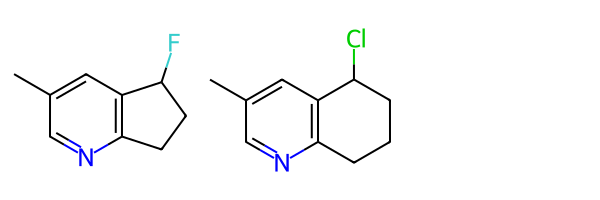

In [150]:
ms = [Chem.MolFromSmiles(s) for s in ("CC1=CC2=C(CCC2F)N=C1","CC1=CC2=C(CCCC2Cl)N=C1")]
Draw.MolsToGridImage(ms)

In [151]:
ps = rdRGroupDecomposition.RGroupDecompositionParameters()
ps.onlyMatchAtRGroups = False
ps.doEnumeration = True
rgd,_ = rdRGroupDecomposition.RGroupDecompose([core],ms,asSmiles=True,options=ps)
rgd

[{'Core': 'c1nc2c(cc1[*:1])C([*:2])CC2', 'R1': 'C[*:1]', 'R2': 'F[*:2]'},
 {'Core': 'c1nc2c(cc1[*:1])C([*:2])CCC2', 'R1': 'C[*:1]', 'R2': 'Cl[*:2]'}]

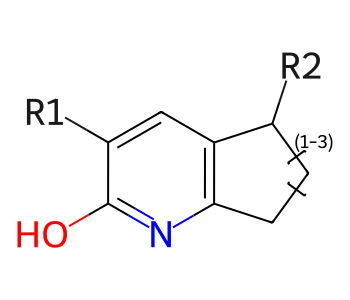

In [153]:
core = Chem.MolFromSmiles('[*]C1=CC2=C(CCC2[*])N=C1O |$R1;;;;;;;;R2;;$,LN:6:1.3|')
core

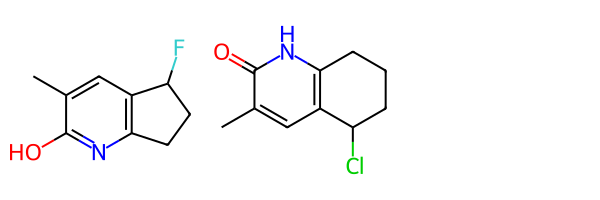

In [154]:
ms = [Chem.MolFromSmiles(s) for s in ("CC1=CC2=C(CCC2F)N=C1O","CC1=CC2=C(CCCC2Cl)NC1=O")]
Draw.MolsToGridImage(ms)

In [155]:
ps = rdRGroupDecomposition.RGroupDecompositionParameters()
ps.onlyMatchAtRGroups = False
ps.doEnumeration = True
ps.doTautomers = True

rgd,_ = rdRGroupDecomposition.RGroupDecompose([core],ms,asSmiles=True,options=ps)
rgd

[{'Core': 'Oc1nc2c(cc1[*:1])C([*:2])CC2', 'R1': 'C[*:1]', 'R2': 'F[*:2]'},
 {'Core': 'O=c1[nH]c2c(cc1[*:1])C([*:2])CCC2',
  'R1': 'C[*:1]',
  'R2': 'Cl[*:2]'}]

### Generalized substructure search and the SubstructLibrary
v2023.09.2

In [7]:
import pickle
with open('/home/glandrum/Datasets/ChEMBL/chembl33_ssslib.pkl','rb') as inf:
    sslib = pickle.load(inf)
len(sslib)

2331008

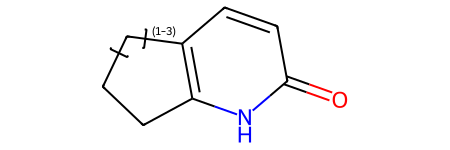

In [21]:
core = Chem.MolFromSmiles('C1=CC2=C(CCC2)NC1=O |LN:6:1.3|')
core

In [33]:
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.adjustRingCount = True
qcore = Chem.AdjustQueryProperties(core,ps)
xqm = rdGeneralizedSubstruct.CreateExtendedQueryMol(qcore)
res = sslib.GetMatches(xqm)
len(res)

783

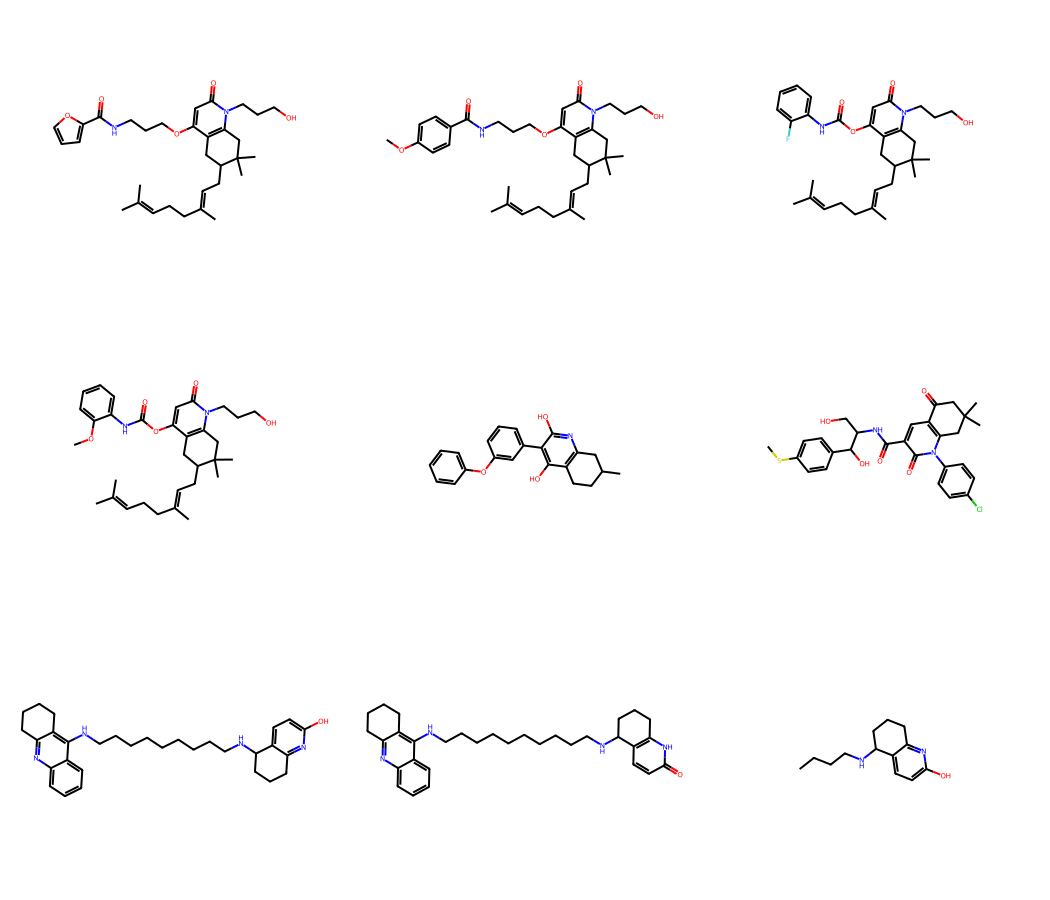

In [34]:
matches = [sslib.GetMol(i) for i in res[:9]]
Draw.MolsToGridImage(matches,subImgSize=(350,300))

## Allowing use of atom and bond properties in the substructure matching
(2023.09)

Developer: Rachel Walker

This provides another way to dynamically control substructure matching.

In [41]:
m = Chem.MolFromSmiles('OCCO')
m2 = Chem.Mol(m)

m.GetAtomWithIdx(0).SetIntProp('match_prop',1)
m2.GetAtomWithIdx(0).SetIntProp('match_prop',1)

ps = Chem.SubstructMatchParameters()
ps.uniquify = False
print(m.GetSubstructMatches(m2,ps))


((0, 1, 2, 3), (3, 2, 1, 0))


In [42]:
ps.atomProperties = ["match_prop"]
m.GetSubstructMatches(m2,ps)

((0, 1, 2, 3),)

We can do the same thing with bonds:

In [43]:
m = Chem.MolFromSmiles('OCCO')
m2 = Chem.Mol(m)

m.GetBondWithIdx(0).SetIntProp('match_prop',1)
m2.GetBondWithIdx(0).SetIntProp('match_prop',1)

ps = Chem.SubstructMatchParameters()
ps.uniquify = False
ps.bondProperties = ["match_prop"]

print(m.GetSubstructMatches(m2,ps))


((0, 1, 2, 3),)


## Improved support for organometallics
(2023.03, 2023.09)

Developer David Cosgrove, funded by Syngenta


In [6]:
from rdkit import Chem
from rdkit.Chem import Draw

In [7]:
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

### Part 1: adding a cleanup step to convert single bonds between metals and hypervalent atoms to dative bonds.

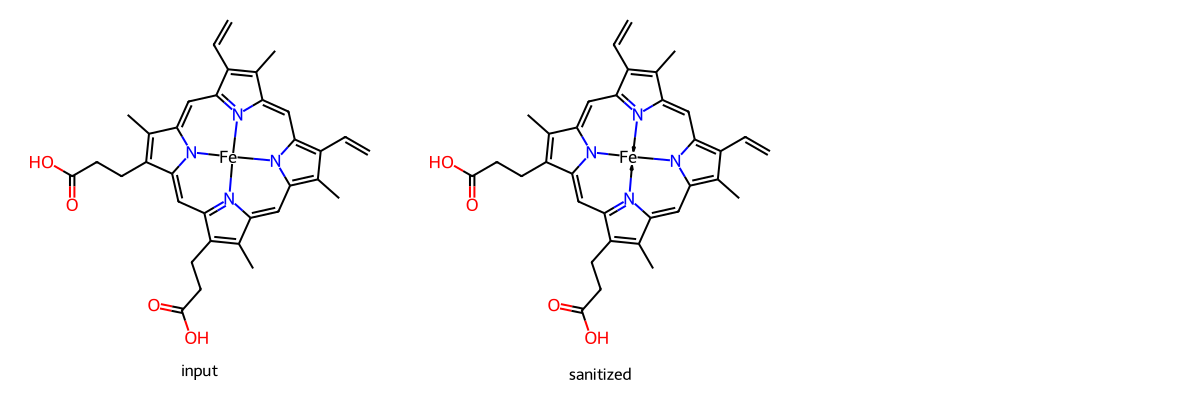

In [8]:
smiles='CC1=C(CCC(O)=O)C2=[N]3C1=Cc1c(C)c(C=C)c4C=C5C(C)=C(C=C)C6=[N]5[Fe]3(n14)n1c(=C6)c(C)c(CCC(O)=O)c1=C2'
m1 = Chem.MolFromSmiles(smiles,
                       sanitize=False)
m2 = Chem.MolFromSmiles(smiles)

m1.UpdatePropertyCache(strict=False)
Draw.MolsToGridImage((m1,m2),subImgSize=(400,400),legends=('input','sanitized'))

You can skip this step if you like by turning it off when you do sanitization:

In [9]:
m1 = Chem.MolFromSmiles(smiles,
                       sanitize=False)
Chem.SanitizeMol(m1,sanitizeOps = Chem.SANITIZE_ALL^Chem.SANITIZE_CLEANUP_ORGANOMETALLICS)

[06:14:30] unrecognized bond type[06:14:30] unrecognized bond type[06:14:32] Explicit valence for atom # 9 N, 4, is greater than permitted


AtomValenceException: Explicit valence for atom # 9 N, 4, is greater than permitted

### Part 2: Switching back and forth between dative and haptic representations

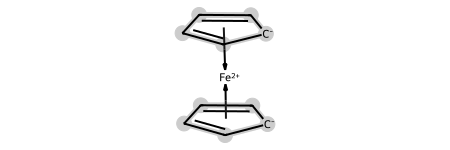

In [10]:
mb = '''ferrocene
     RDKit          2D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 12 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -34.237900 13.261800 0.000000 0 CHG=-1
M  V30 2 C -35.057400 14.266900 0.000000 0
M  V30 3 C -37.855700 14.284400 0.000000 0
M  V30 4 C -38.759100 13.293300 0.000000 0
M  V30 5 C -36.552000 12.683200 0.000000 0
M  V30 6 C -34.152900 8.363300 0.000000 0 CHG=-1
M  V30 7 C -34.972400 9.368400 0.000000 0
M  V30 8 C -37.770600 9.385900 0.000000 0
M  V30 9 C -38.674100 8.394800 0.000000 0
M  V30 10 C -36.450300 7.767900 0.000000 0
M  V30 11 Fe -36.435100 10.904500 0.000000 0 CHG=2
M  V30 12 * -36.522400 13.604600 0.000000 0
M  V30 13 * -36.404100 8.656100 0.000000 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 9 12 11 ENDPTS=(5 2 3 4 5 1) ATTACH=ALL
M  V30 2 1 1 5
M  V30 3 2 4 5
M  V30 4 1 4 3
M  V30 5 2 2 3
M  V30 6 1 1 2
M  V30 7 1 6 10
M  V30 8 2 9 10
M  V30 9 1 9 8
M  V30 10 2 7 8
M  V30 11 1 6 7
M  V30 12 9 13 11 ENDPTS=(5 7 8 9 10 6) ATTACH=ALL
M  V30 END BOND
M  V30 END CTAB
M  END
$$$$'''
m = Chem.MolFromMolBlock(mb)
m

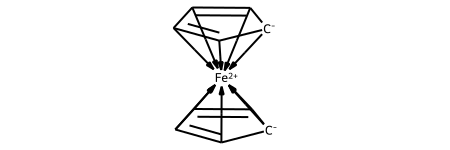

In [11]:
dative_m = Chem.HapticBondsToDative(m)
dative_m

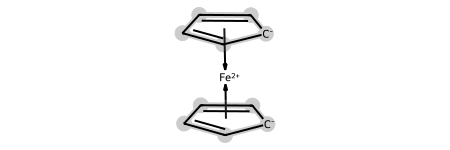

In [12]:
hapt_m = Chem.DativeBondsToHaptic(dative_m)
hapt_m

In [13]:
m.Debug()

Atoms:
	0 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	6 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	7 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	8 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	9 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	10 26 Fe chg: 2  deg: 2 exp: 2 imp: 0 hyb: SP3
	11 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
	12 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
Bonds:
	0 11->10 order: D
	1 0->4 order: a conj?: 1 aromatic?: 1
	2 3->4 order: a conj?: 1 aromatic?: 1
	3 3->2 order: a conj?: 1 aromatic?: 1
	4 1->2 order: a conj?: 1 aromatic?: 1
	5 0->1 order: a conj?: 1 aromatic?: 1
	6 5->9 order: a conj?: 1 aromatic?: 1
	7 8->9 order: a conj?: 1

In [14]:
hapt_m.UpdatePropertyCache()
hapt_m.Debug()

Atoms:
	0 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	2 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	3 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	4 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	5 6 C chg: -1  deg: 2 exp: 3 imp: 0 hyb: SP2 arom?: 1
	6 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	7 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	8 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	9 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: SP2 arom?: 1
	10 26 Fe chg: 2  deg: 2 exp: 2 imp: 0 hyb: SP3
	11 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
	12 0 * chg: 0  deg: 1 exp: 0 imp: 0 hyb:  query: AtomNull
Bonds:
	0 0->4 order: a conj?: 1 aromatic?: 1
	1 3->4 order: a conj?: 1 aromatic?: 1
	2 3->2 order: a conj?: 1 aromatic?: 1
	3 1->2 order: a conj?: 1 aromatic?: 1
	4 0->1 order: a conj?: 1 aromatic?: 1
	5 5->9 order: a conj?: 1 aromatic?: 1
	6 8->9 order: a conj?: 1 aromatic?: 1
	7 8-

### Disconnecting organometallics: sometimes it's better to just fragment the molecule and analyze the ligands and metal separately

In [15]:
from rdkit.Chem.MolStandardize import rdMolStandardize
Chem.MolToSmiles(rdMolStandardize.DisconnectOrganometallics(hapt_m))

[06:15:08] Initializing MetalDisconnector
[06:15:08] Running MetalDisconnector


'[Fe+2].c1cc[cH-]c1.c1cc[cH-]c1'

In [16]:
Chem.MolToSmiles(rdMolStandardize.DisconnectOrganometallics(dative_m))

[06:15:09] Initializing MetalDisconnector
[06:15:09] Running MetalDisconnector
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C
[06:15:09] Removed covalent bond between Fe and C


'[Fe+2].c1cc[cH-]c1.c1cc[cH-]c1'

By the way: you can make the MolStandardize code less verbose:

In [17]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
Chem.MolToSmiles(rdMolStandardize.DisconnectOrganometallics(dative_m))

'[Fe+2].c1cc[cH-]c1.c1cc[cH-]c1'

In [18]:
RDLogger.EnableLog('rdApp.info')